# Some ideas for the MeLi 2021 Challenge

Disclaimer: At the time of the challenge I couldn't really participate until late and due to hardware constraints I didn't even start working on it. Because of such constraints EDA is minimal and done *after* baselines are tried (basically analysis), in an effort to reduce memory impact. As can be seen, only a subset of the data is used too for the same reasons. This notebook covers **very** simple estimators based on strong assumptions so that only NumPy/SciPy operations are required and CPU/RAM consumption is, again, minimized. They perform (surprisingly?) well, and some other conclusions are drawn, which are listed at the end.

In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import csv
import pickle
import joblib
import matplotlib.pyplot as plt
import multiprocessing as mp
from itertools import chain, islice
from datetime import timedelta
import jsonlines
import seaborn as sns
from pathlib import Path
import multiprocessing as mp
from itertools import chain, islice
from functools import partial
import polars as pl
import scipy.stats as stats

from result_save import load_or_exec # load_or_exec

data_dir = Path("data/")
sns.set_theme()

## EDA

**TODO**, on PolaRS since 16 GB RAM is on the verge of overflow with Pandas

## Validation set and preparations

This is mostly taken from the workshop notebook +- some delta and other, more-specialized tools like building multiple targets for ensembles.

In [3]:
DAYS_TO_PREDICT = 30

In [4]:
train_df = pd.read_parquet(data_dir/'train_data.parquet', columns=["sku","date","sold_quantity"])
train_df.date = pd.to_datetime(train_df.date)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37660279 entries, 0 to 37660278
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   sku            int64         
 1   date           datetime64[ns]
 2   sold_quantity  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 862.0 MB


In [6]:
print(train_df.date.min(), train_df.date.max())
split_date = (train_df.date.max()-timedelta(days=DAYS_TO_PREDICT)).date()
print(split_date)

2021-02-01 00:00:00 2021-03-31 00:00:00
2021-03-01


In [7]:
#separate the last 30 days for validation
data_val = train_df.loc[(train_df.date > str(split_date))]

#use the rest as training
data_train = train_df.loc[(train_df.date <= str(split_date))]

In [8]:
%%time
@load_or_exec("data/val_set_42.pickle")
def create_validation_set(dataset):
    np.random.seed(42)
    print('Sorting records...')
    temp_pd = dataset.loc[:, ['sku','date','sold_quantity']].sort_values(['sku','date'])

    print('Grouping quantity...')
    temp_dict = temp_pd.groupby('sku').agg({'sold_quantity':lambda x: [i for i in x]})['sold_quantity'].to_dict()

    result = []
    for idx, list_quantity in tqdm(temp_dict.items(), desc='Making targets...'):
        cumsum = np.array(list_quantity).cumsum()
        stock_target = 0
        if cumsum[-1] > 0 and len(cumsum)==DAYS_TO_PREDICT:
            
            #choose a random target different from 0
            while stock_target == 0:
                stock_target = np.random.choice(cumsum)
                
            #get the first day with this amounnt of sales
            day_to_stockout = np.argwhere(cumsum==stock_target).min() + 1
            
            #add to a list
            result.append({'sku':idx, 'target_stock':stock_target, 'inventory_days':day_to_stockout})
    return result

#generate target for the 30 days of validation
val_dataset = create_validation_set(data_val)

CPU times: total: 828 ms
Wall time: 845 ms


In [9]:
# precalculate the cumulative target so RPS doesn't have to do it every time
@load_or_exec("data/val_cum_matrix_42.joblib",save_f=joblib.dump,load_f=joblib.load)
def make_one_hot_cum_matrix(valid_set):
    y_true_val = np.array([x['inventory_days'] for x in valid_set])
    y_true_one_hot = np.zeros((len(y_true_val),DAYS_TO_PREDICT), dtype=float)
    y_true_one_hot[range(len(y_true_val)), y_true_val-1] = 1
    return y_true_one_hot.cumsum(axis=1)

y_true_cum = make_one_hot_cum_matrix(val_dataset)

In [10]:
# sanity check
y_true_cum.shape

(576783, 30)

In [11]:
def rps_distro(y_pred):
    return ((y_true_cum - y_pred.cumsum(axis=1))**2).sum(axis=1)

def rps(y_pred):
    """
    Input
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    return rps_distro(y_pred).mean()

In [12]:
# leaving these ones for usage on 1 item and such
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

## Models

### Uniform baseline

This is taken from the _baseline_ notebook done in the challenge workshop.

In [13]:
unif_value = round(1/DAYS_TO_PREDICT,4)
y_pred_uniform = np.full_like(y_true_cum, fill_value=unif_value)

In [14]:
uniform_score_distro = rps_distro(y_pred_uniform)
print('Uniform model got a validation RPS of: ',uniform_score_distro.mean())

Uniform model got a validation RPS of:  4.8660818774579875


In [15]:
uniform_score_distro

array([2.50755495, 6.89215495, 9.48655495, ..., 4.91415495, 6.91515495,
       2.71035495])

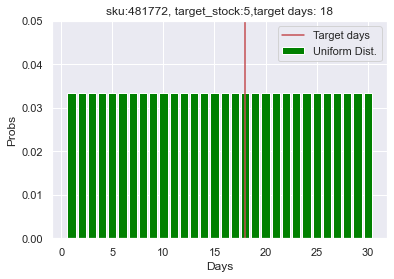

In [16]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.05])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.ones(DAYS_TO_PREDICT)/DAYS_TO_PREDICT, color='green')

plt.xlabel('Days')
plt.ylabel('Probs')
plt.legend(['Target days', 'Uniform Dist.'])
plt.show()

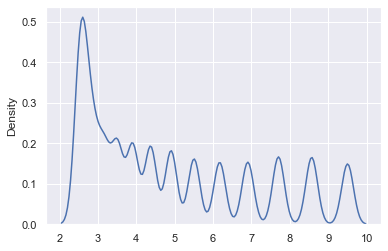

In [17]:
# distribution of RPS values
sns.kdeplot(x=uniform_score_distro)
plt.show()

Ok, what that means is there's a non-contiguous tail there. Plotting histograms and things in order to better understand that.

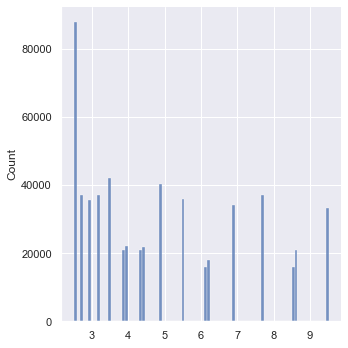

In [18]:
sns.displot(x=uniform_score_distro, stat='count')
plt.show()

Of course, there's only 30 possible values for the RPS for the constant estimator. High low-RPS count (~1/7 below 2.6, ~1/3 below 3.2) indicates that applying a bias to the center may be a good idea, may it be by inflating variance when predicting extremes or using some bayesian prior. Obviously we didn't need to train any model to realize that, but it's still worth noting.

### Linear model baseline

The idea was also taken from the _baseline_ notebook but the original formulation took **way too much** time for 3 cores, so I'll be using a way faster variation that requires shifting the data model to the pivoted matrix of SKU x date -> sold_quantity. Care should be taken that the linearity assumption refers to the sold_quantity/day variable, **not** on the days-until-stockout variable (which is the inverse).

In [19]:
# get global metrics for later
global_mu = data_train.sold_quantity.mean()
global_std = data_train.sold_quantity.std()
print(global_mu, global_std)

0.9860988953405845 11.070805728028184


In [20]:
%%time

@load_or_exec("data/X_train_no_stock.joblib",save_f=joblib.dump, load_f=joblib.load)
def pivot_train():
    return data_train.pivot(index='sku',columns='date',values='sold_quantity')

val_skus, target_stocks = zip(*[(x['sku'],x['target_stock']) for x in val_dataset])
target_series = pd.Series(data=target_stocks, index=val_skus)
X_train_no_stock = pivot_train()
X_train_aligned_no_stock, _ = X_train_no_stock.align(target_series, copy=False, join='right', axis=0)

print(len(X_train_no_stock), len(X_train_aligned_no_stock), len(val_dataset))

X_train_aligned_no_stock.head()

639351 576783 576783
CPU times: total: 1.86 s
Wall time: 1.95 s


date  2021-02-01  2021-02-02  2021-02-03  2021-02-04  2021-02-05  2021-02-06  \
0            0.0         0.0         0.0         0.0         0.0         0.0   
1            0.0         0.0         0.0         0.0         0.0         0.0   
3            0.0         1.0         0.0         1.0         0.0         1.0   
4            0.0         0.0         0.0         0.0         0.0         0.0   
5            0.0         0.0         0.0         0.0         0.0         0.0   

date  2021-02-07  2021-02-08  2021-02-09  2021-02-10  ...  2021-02-20  \
0            0.0         0.0         0.0         0.0  ...         0.0   
1            0.0         0.0         0.0         0.0  ...         0.0   
3            0.0         0.0         1.0         0.0  ...         1.0   
4            0.0         0.0         6.0         5.0  ...         0.0   
5            0.0         0.0         0.0         0.0  ...         0.0   

date  2021-02-21  2021-02-22  2021-02-23  2021-02-24  2021-02-25  2021-02-26  \
0            0.0         0.0         0.0         0.0         0.0         0.0   
1            0.0         2.0         2.0         0.0         0.0         0.0   
3            0.0         1.0         0.0         0.0         0.0         0.0   
4            1.0         1.0        12.0         0.0         1.0         0.0   
5            0.0         0.0         0.0         0.0         0.0         0.0   

date  2021-02-27  2021-02-28  2021-03-01  
0            0.0         0.0         0.0  
1            1.0         0.0         2.0  
3            0.0         0.0         0.0  
4            1.0         0.0         2.0  
5            0.0         0.0         1.0  

[5 rows x 29 columns]

In [21]:
# check that columns (dates) are sorted in ascending order
_ = X_train_aligned_no_stock.columns
print("Columns are sorted" if np.all(_[:-1] <= _[1:]) else "Columns are NOT sorted")

Columns are sorted


In [22]:
# TESTING
data = X_train_aligned_no_stock.iloc[:, -14:]
data.head()

date  2021-02-16  2021-02-17  2021-02-18  2021-02-19  2021-02-20  2021-02-21  \
0            0.0         0.0         0.0         0.0         0.0         0.0   
1            0.0         0.0         0.0         0.0         0.0         0.0   
3            0.0         0.0         1.0         0.0         1.0         0.0   
4            1.0         1.0         1.0         0.0         0.0         1.0   
5            0.0         0.0         0.0         0.0         0.0         0.0   

date  2021-02-22  2021-02-23  2021-02-24  2021-02-25  2021-02-26  2021-02-27  \
0            0.0         0.0         0.0         0.0         0.0         0.0   
1            2.0         2.0         0.0         0.0         0.0         1.0   
3            1.0         0.0         0.0         0.0         0.0         0.0   
4            1.0        12.0         0.0         1.0         0.0         1.0   
5            0.0         0.0         0.0         0.0         0.0         0.0   

date  2021-02-28  2021-03-01  
0            0.0         0.0  
1            0.0         2.0  
3            0.0         0.0  
4            0.0         2.0  
5            0.0         1.0

In [23]:
# TESTING
# number of NaNs per row
data.isna().sum(axis=1).value_counts()

0     563389
1       1343
8       1322
9       1292
2       1286
7       1193
6       1167
3       1112
10      1078
13      1036
14       998
4        441
11       421
5        361
12       344
dtype: int64

In [28]:
class LinearModelNP:
    def __init__(self, 
                 global_mu, 
                 global_std,
                 last_n_days, 
                 normalize=True,
                 variance_scales=False):
        
        self.normalize = normalize
        self.last_n_days = last_n_days
        self.border_cases = 0
        self.uniforms = 0
        self.variance_scales = variance_scales
        self.global_mu = global_mu
        self.global_std = global_std
        
    def fit(self, X_train):
        # restrict to last n days
        data = X_train.iloc[:, -self.last_n_days:]
        
        # get means for every row, border cases get their moments replaced with global ones
        self.means = data.mean(axis=1).fillna(0).to_numpy()
        self.border_cases = (self.means==0).sum()  # border cases are NaN or all-0 rows
        self.means[self.means==0] = self.global_mu
        
        self.stds = data.std(axis=1).fillna(0).to_numpy()
        self.stds[self.stds==0] = global_std
        
        
        return self
        
    def predict_mu_sigma(self, target_stocks):
        # WARNING: it is ASSUMED that the train data and target_stocks are SKU-aligned
        days_to_stockout = target_stocks / self.means
        
        # which one scales linearly with days, std or variance?
        if self.variance_scales:
            scaler = np.sqrt(days_to_stockout)  # variance scales linearly
        else:
            scaler = days_to_stockout           # std scales linearly
        
        std_days = self.stds / self.means * scaler
        
        return days_to_stockout.to_numpy(), std_days.to_numpy()
    
    def predict(self, target_stocks):
        # WARNING: it is ASSUMED that the train data and target_stocks are SKU-aligned
        # days_to_stockout is calculated as a function of the mean
        mean_days, std_days = self.predict_mu_sigma(target_stocks)
        
        y_pred_normal = np.empty((len(target_stocks),DAYS_TO_PREDICT), dtype=float)

        pred_days = np.arange(1,DAYS_TO_PREDICT+2)
        assert(len(pred_days[1:] - pred_days[:-1])==DAYS_TO_PREDICT)
        
        for idx, mu, sigma in tqdm(zip(range(len(self.means)),mean_days, std_days), 
                                   total=len(target_stocks),
                                   desc='generating preds...'):
            distro = stats.norm(mu, sigma)
            cdfs = distro.cdf(pred_days)
            res = cdfs[1:] - cdfs[:-1]
            if np.sum(res)==0:   # if norm gives prob=0, replace with uniform
                res = unif_value # broadcasting is nice
                self.uniforms += 1 # count these cases
            y_pred_normal[idx,] = res
            
            
        # normalize
        if self.normalize:
            y_pred_normal = y_pred_normal / y_pred_normal.sum(axis=1).reshape(-1,1)
        return y_pred_normal

In [29]:
%%time
@load_or_exec("data/linear_scale_on_std.joblib",save_f=joblib.dump, load_f=joblib.load)
def train_linear_std():
    return LinearModelNP(global_mu=global_mu, 
                         global_std=global_std,
                         last_n_days=14, 
                         normalize=True, 
                         variance_scales=False).fit(X_train_aligned_no_stock)

linear_std_model = train_linear_std()

CPU times: total: 15.6 ms
Wall time: 10 ms


In [30]:
# number of uniforms and border cases
linear_std_model.uniforms, linear_std_model.border_cases

(0, 128850)

In [31]:
%%time
@load_or_exec("predictions/linear_on_std.joblib",save_f=joblib.dump, load_f=joblib.load)
def make_linear_std_predictions():
    return linear_std_model.predict(target_series)

linear_std_preds = make_linear_std_predictions()

CPU times: total: 109 ms
Wall time: 117 ms


In [32]:
linear_std_score_distro = rps_distro(linear_std_preds)
print('Normal model got a validation RPS of: ',linear_std_score_distro.mean())

Normal model got a validation RPS of:  4.527372378606083


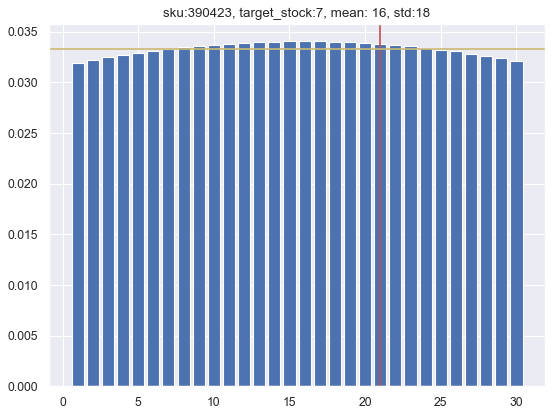

In [33]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()

idx = np.argwhere(target_series.index == sku).flat[0]
distro_hat = linear_std_preds[idx,]

mean_to_stockout = stock / linear_std_model.means[idx]
std_to_stockout = linear_std_model.stds[idx] * mean_to_stockout

plt.bar(range(1,31), distro_hat)
plt.axvline(days, color='r')
plt.title('sku:{}, target_stock:{}, mean: {}, std:{}'.format(int(sku), 
                                                             stock,
                                                             round(mean_to_stockout), 
                                                             round(std_to_stockout)))
plt.axhline(1/30, color='y')
plt.show()

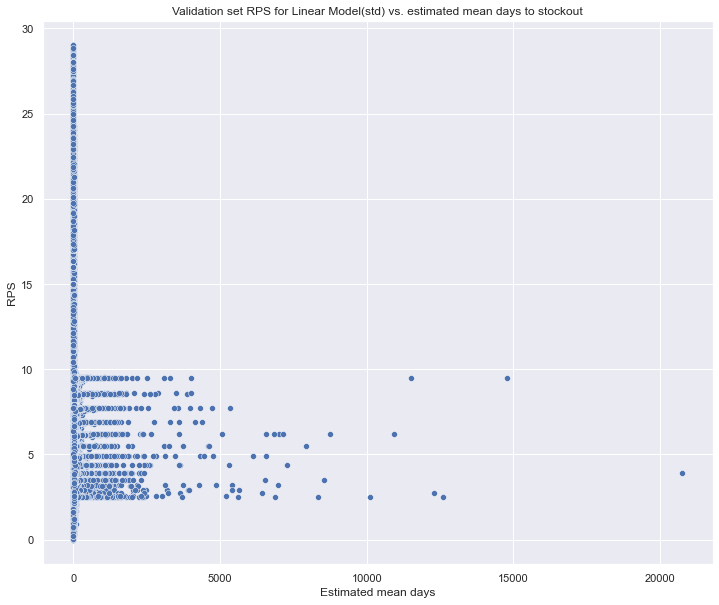

In [34]:
# comparing RPS with estimated days
mean_days_linear, _ = linear_std_model.predict_mu_sigma(target_series)

def plot_RPS_vs_estimated_mean(mean_days, RPS_distro, name,truncate_to_valid=False):
    if truncate_to_valid:
        valid_idxs = mean_days <= 30
        mean_days = mean_days[valid_idxs]
        RPS_distro = RPS_distro[valid_idxs]
    fig, ax = plt.subplots(figsize=(12,10))

    sns.scatterplot(x=mean_days, y=RPS_distro)
    ax.set_xlabel("Estimated mean days")
    ax.set_ylabel("RPS")
    ax.set_title(f"Validation set RPS for {name} vs. estimated mean days to stockout"+\
                    ("- Truncated to valid estimated mean days" if truncate_to_valid else "")
                )
    plt.show()

plot_RPS_vs_estimated_mean(mean_days_linear, linear_std_score_distro,"Linear Model(std)")

In [35]:
# we see a whole lot of points with moderate RPS values and HUGE numbers of estimated mean days
np.mean(mean_days_linear > 30)

0.22549728407390648

So 50% of this model doing well is being basically a uniform distribution for large estimated mean days, what this does is clipping the RPS score. But how well does it perform on days with a valid mean estimation?

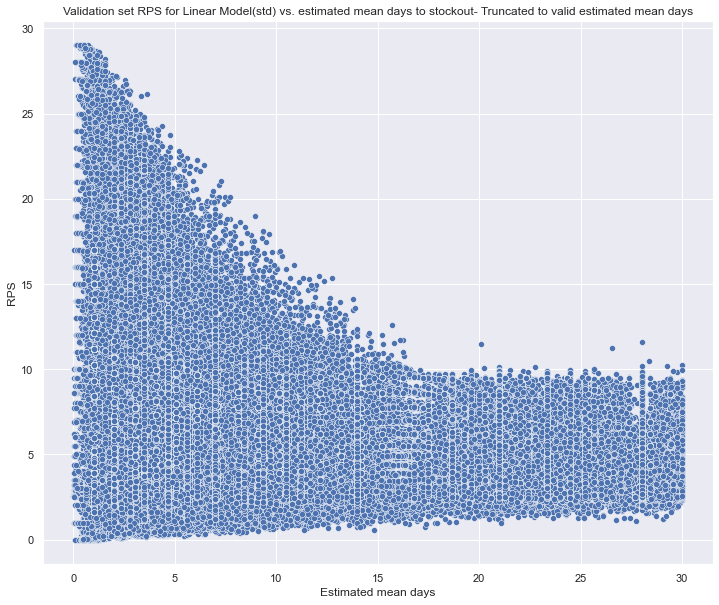

In [36]:
plot_RPS_vs_estimated_mean(mean_days_linear, linear_std_score_distro,"Linear Model(std)",True)

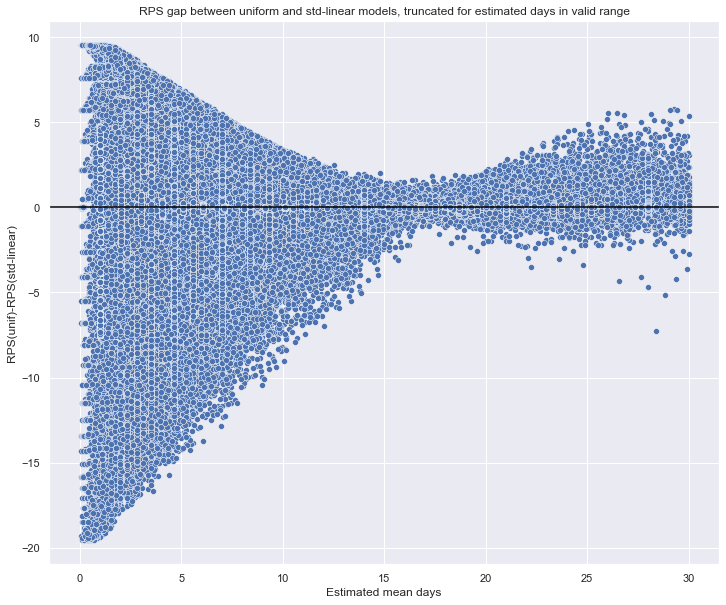

In [37]:
# how better than the uniform model is it?
truncated_mean_days = mean_days_linear[mean_days_linear <=30]
truncated_unif_score_distro = uniform_score_distro[mean_days_linear <=30]
truncated_normal_score_distro = linear_std_score_distro[mean_days_linear <=30]
truncated_normal_unif_RPS_gap = truncated_unif_score_distro - truncated_normal_score_distro

fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(x=truncated_mean_days, y=truncated_normal_unif_RPS_gap)
ax.set_xlabel("Estimated mean days")
ax.set_ylabel("RPS(unif)-RPS(std-linear)")
ax.set_title("RPS gap between uniform and std-linear models, truncated for estimated days in valid range")
ax.axhline(0, color='black')
plt.show()

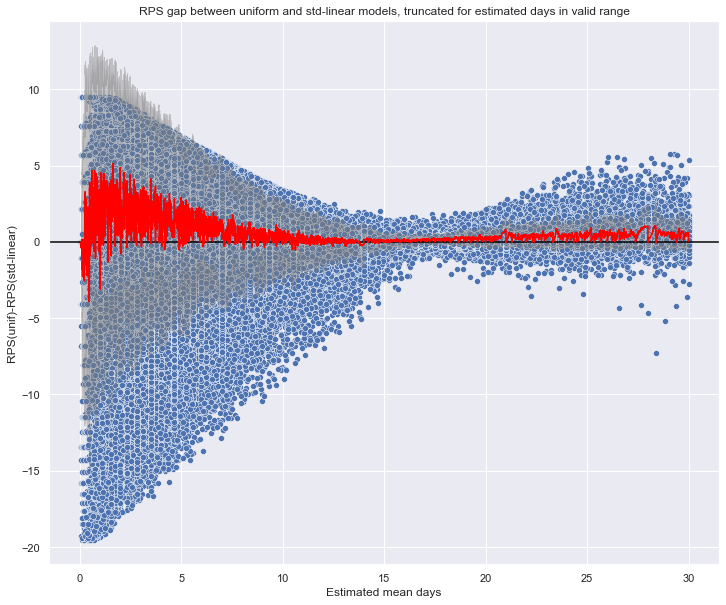

In [39]:
sorted_args = np.argsort(truncated_mean_days)
sorted_truncated_mean_days = truncated_mean_days[sorted_args]
sorted_truncated_gaps_windows = pd.Series(truncated_normal_unif_RPS_gap[sorted_args]).rolling(100)

rolling_mus = sorted_truncated_gaps_windows.mean().to_numpy()
rolling_stds = sorted_truncated_gaps_windows.std().to_numpy()

fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(x=truncated_mean_days, y=truncated_normal_unif_RPS_gap)
ax.set_xlabel("Estimated mean days")
ax.set_ylabel("RPS(unif)-RPS(std-linear)")
ax.set_title("RPS gap between uniform and std-linear models, truncated for estimated days in valid range")
ax.axhline(0, color='black')

ax.plot(sorted_truncated_mean_days,rolling_mus, color='red')
ax.fill_between(sorted_truncated_mean_days, rolling_mus - rolling_stds, rolling_mus + rolling_stds, alpha=0.4, color='gray')
plt.show()

Note that in the above plot, negative tendencies indicate that the uniform model performs better than the normal one.
As seen, there is *a lot* of noise, but it can be said that the normal model performs better than the uniform one for lower estimated mean days, and just slightly better in the higher-end of the spectrum.

### Bernoulli model

We assume an i.i.d. Bernoulli process each day where for each trial there's a probability *p* of ending the day and *1-p* of selling an item instead.
Following this model, the number of sold items on day i + 1 follows a geometric distribution $X_i + 1 \sim Geo(p)$ (+1 accounts for the failed trial).
After that, the number of days until *k* items are sold -1 follows a negative binomial distribution $N_k -1 \sim NB(k, 1-p)$ using the [SciPy definition](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html) where *failures* (finished days) are counted until a fixed number of *successes* (sold items) occur. 
For example, let $S, D$ represent sold item and end-of-day results (respectively) for each trial, then for a stock of 5 items a possible outcome is $SSNNSSS$ indicating that stock ran out on the third day because of the 2 failures, hence the number of finished days is 2 but the stock runs out on the third. This +1 must happen always because the last occurrence is always a success for this model (thus the need to "append an $N$ at the end"). Notably, because days range from 1 to 30 but arrays use indexes from 0 to 29, the NB result can be used directly as the index, i.e. `pred[idx] = P(NB(k,1-p) == idx)`

Since in this model sold quantities+1 are i.i.d. samples from a Geometric distribution, the MLE estimate of *p* is just $\hat{p}=(sold\_quantities.mean()+1)^{-1}$

In [40]:
class NBModel:
    def __init__(self,
                 last_n_days, 
                 global_mu=global_mu,
                 normalize=True):
        self.last_n_days = last_n_days
        self.normalize = normalize
        self.global_mu = global_mu
        
    def fit(self, X_train):
        # restrict to last n days
        data = X_train.iloc[:, -self.last_n_days:]
        
        self.means = data.mean(axis=1).fillna(0).to_numpy()
        self.means[self.means==0] = self.global_mu
        self.probs_endday = 1 / (self.means+1)
        self.probs_selling = 1 - self.probs_endday
        
        return self
    
    def predict(self, target_stocks):
        # WARNING: it is ASSUMED that the train data and target_stocks are SKU-aligned
        
        y_pred = np.empty((len(target_stocks),DAYS_TO_PREDICT), dtype=float)

        # IMPORTANT: note that range changed from (1,31) to (0,29) 
        # This is both because of the -1 in the formulation and NB being a discrete distro (using just pmf instead of cdf)
        pred_args = np.arange(DAYS_TO_PREDICT)
        
        for idx, k, prob_selling in tqdm(zip(range(len(means)),
                                             target_stocks, 
                                             self.probs_selling), 
                                         total=len(target_stocks),
                                         desc='generating preds...'):
            res = 0 # placeholder
            if prob_selling not in {0,1}:     # if mean was 0 it's a border case
                res = stats.nbinom(n=k, p=prob_selling).pmf(pred_args)
            if np.sum(res)==0:   # if NB gives prob=0, replace with uniform
                res = unif_value # broadcasting is nice
            y_pred[idx,] = res

        # normalize
        if self.normalize:
            y_pred = y_pred / y_pred.sum(axis=1).reshape(-1,1)
        return y_pred

In [41]:
%%time
@load_or_exec("data/nb.joblib",save_f=joblib.dump, load_f=joblib.load)
def train_nb():
    return NBModel(last_n_days=14,
                   global_mu = global_mu,
                   normalize=True).fit(X_train_aligned_no_stock)

nb_model = train_nb()

CPU times: total: 15.6 ms
Wall time: 13.9 ms


In [42]:
%%time
@load_or_exec("predictions/nb.joblib",save_f=joblib.dump, load_f=joblib.load)
def make_nb_predictions():
    return nb_model.predict(target_series)

nb_preds = make_nb_predictions()

CPU times: total: 125 ms
Wall time: 128 ms


In [43]:
nb_score_distro = rps_distro(nb_preds)
print('Negative Binomial model got a validation RPS of: ',nb_score_distro[~np.isnan(nb_score_distro)].mean())

Negative Binomial model got a validation RPS of:  6.019447313270992


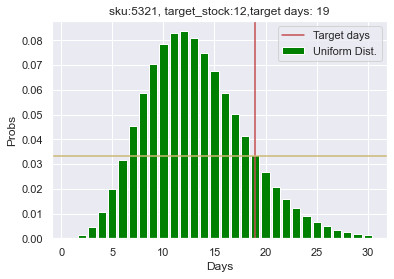

In [44]:
# random sample
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
idx = np.argwhere(target_series.index == sku).flat[0]
distro_hat = nb_preds[idx,]

#plt.ylim([0,1])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31),distro_hat, color='green')

plt.xlabel('Days')
plt.ylabel('Probs')
plt.legend(['Target days', 'Uniform Dist.'])
plt.axhline(1/30, color='y')
plt.show()

Basically, the model may indeed be *bad at predicting* but its main problem is **it lacks dispersion**.

<AxesSubplot:ylabel='Density'>

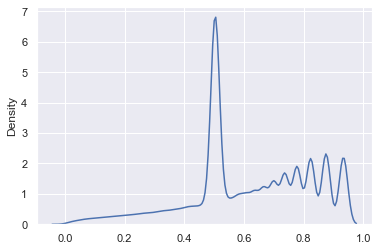

In [45]:
# plotting p's, see what's going on
sns.kdeplot(nb_model.probs_endday)

<AxesSubplot:ylabel='Proportion'>

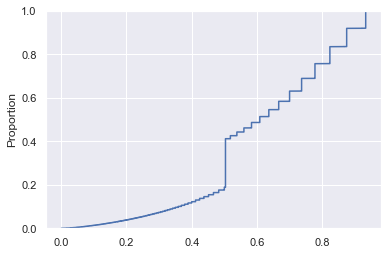

In [46]:
sns.ecdfplot(nb_model.probs_endday)

Note that given $X \sim NB(k,p_V)$, $E[X]=\frac{k(1-p)}{p}, Var(X) = \frac{k(1-p)}{p^2}= E[X] \cdot \frac{1}{p}$ so variance is a scaling of the mean, inversely proportional to the probability of closing. **Variance is very low even if $p_C$ values are high**, which is of course the result of many rows with many 0s. One option is to use a Bayesian beta prior for *p* in order to push it towards some value but not even SciPy implements the posterior predictive BetaNB distribution; the other option is to use a zero-inflated model and see if there's improvement.

Also the spike at ~0.5 is due to the imputing of global average which is approx. 1 and so $(global\_avg+1)^{-1} \approx \frac{1}{2}$.

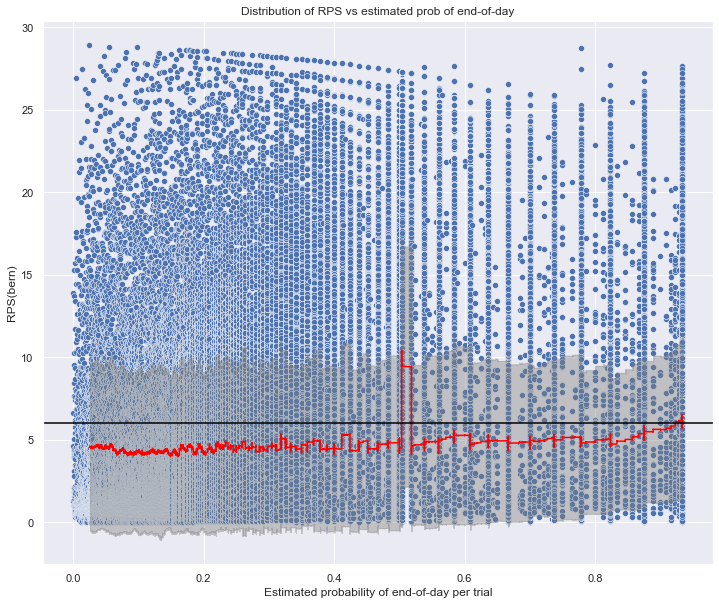

In [47]:
# RPS vs prob_closing
train_data = X_train_aligned_no_stock.iloc[:, -14:]

zeroes_per_row = (train_data == 0).sum(axis=1).to_numpy()

sorted_args_prob_closing = np.argsort(nb_model.probs_endday)
sorted_prob_closing = nb_model.probs_endday[sorted_args_prob_closing]
sorted_nb_distro = nb_score_distro[sorted_args_prob_closing]

nb_distro_windows = pd.Series(sorted_nb_distro).rolling(1000)

rolling_mus = nb_distro_windows.mean().to_numpy()
rolling_stds = nb_distro_windows.std().to_numpy()

fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(x=sorted_prob_closing, y=sorted_nb_distro)
ax.set_xlabel("Estimated probability of end-of-day per trial")
ax.set_ylabel("RPS(bern)")
ax.set_title("Distribution of RPS vs estimated prob of end-of-day")

ax.plot(sorted_prob_closing,rolling_mus, color='red')
ax.fill_between(sorted_prob_closing, rolling_mus - rolling_stds, rolling_mus + rolling_stds, alpha=0.4, color='gray')

ax.axhline(y=nb_score_distro.mean(), color='black')

plt.show()

Two important insights:
* the model is performing very poorly with the global metrics, should be replaced with uniform model in those cases
* the mean RPS on the lower end of end-of-day probs is substantially lower than for the higher end. 

In [48]:
(sorted_nb_distro[sorted_prob_closing<0.4].mean(), 
 sorted_nb_distro[sorted_prob_closing>0.6].mean()
)

(4.490304404353216, 5.147433440296135)

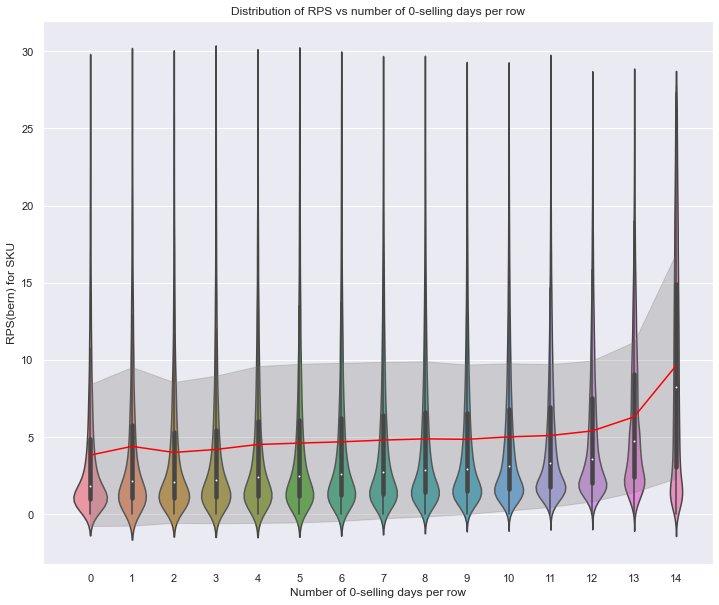

In [49]:
# plot number of 0s per row vs RPS
fig, ax = plt.subplots(figsize=(12,10))
sns.violinplot(x=zeroes_per_row, y=nb_score_distro)
ax.set_xlabel("Number of 0-selling days per row")
ax.set_ylabel("RPS(bern) for SKU")
ax.set_title("Distribution of RPS vs number of 0-selling days per row")

values = np.unique(zeroes_per_row)
buckets = [nb_score_distro[zeroes_per_row==v] for v in values]
nb_means_per_0 = np.array([bucket.mean() for bucket in buckets])
nb_stds_per_0 = np.array([bucket.std() for bucket in buckets])
    
ax.plot(values, nb_means_per_0, color='red')
ax.fill_between(values, nb_means_per_0-nb_stds_per_0, nb_means_per_0+nb_stds_per_0, color='gray', alpha=0.3)
plt.show()

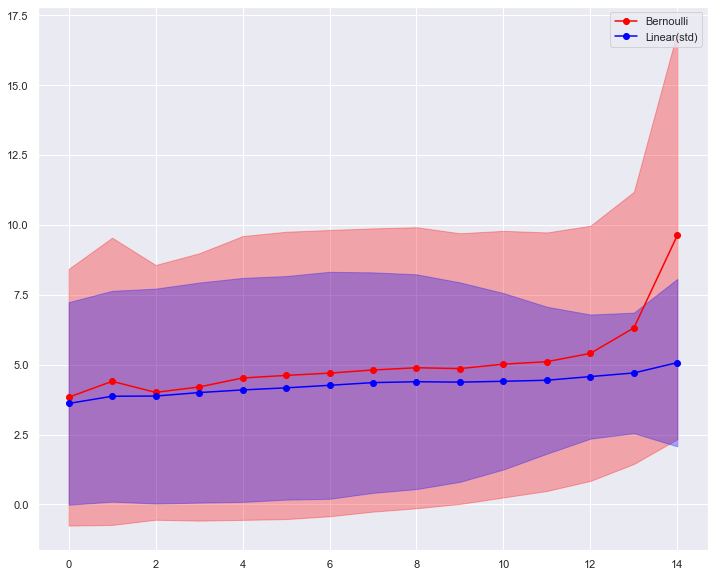

In [50]:
# compare with normal, do they fit better on different situations?
buckets_norm = [linear_std_score_distro[zeroes_per_row==v] for v in values]
norm_means_per_0 = np.array([bucket.mean() for bucket in buckets_norm])
norm_stds_per_0 = np.array([bucket.std() for bucket in buckets_norm])

fig, ax = plt.subplots(figsize=(12,10))
ax.plot(values, nb_means_per_0, 'o-', color='red', label='Bernoulli')
ax.fill_between(values, nb_means_per_0-nb_stds_per_0, nb_means_per_0+nb_stds_per_0, color='red', alpha=0.3)

ax.plot(values, norm_means_per_0, 'o-', color='blue', label='Linear(std)')
ax.fill_between(values, norm_means_per_0-norm_stds_per_0, norm_means_per_0+norm_stds_per_0, color='blue', alpha=0.3)

plt.legend()
plt.grid(True)
plt.show()

It's clear that the linear model performs uniformly better on the validation set. Before dropping the NB model entirely, a check on the total sum of elements is performed, in case a zero-inflated NB model may be better.

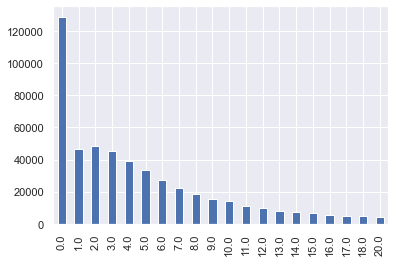

In [51]:
train_data.sum(axis=1).value_counts()[:20].sort_index().plot(kind='bar')
plt.show()

### Zero-inflated Bernoulli/NB Model

*Note 1:* this is intended to work only on rows which have at least one value different from zero and >1 (so max>1). The model will use a uniform prediction for all-zeroes rows.

*Note 2:* since this model accounts for 0s in the data, *NaN*s will be ignored instead of imputing 0s, as long as they are less than 8 (ignoring only 1% of the data as seen below).

*Note 3:* if performing EDA is not viable, fitting a statsmodel `ZeroInflatedNegativeBinomialP` on each of the 576k rows is just unfeasible, *even if only 14 observations were enough*. Hence a worse yet faster, manual, NumPy version is built.

*Note 4:* calculating the PMF is $O(30 \cdot k)$ where $k$ is the target_stock, hence a restriction will be imposed on max k before omitting this and just using uniform. For $k\_max=18000$ this represents an extra reduction of only 5 observations, which is negligible.

Key model aspects:
* Since observations are drawn from $X_i$ where $X_i +1 \sim Geo(p_C)$, restricting observations to positive values gives $X_i+1|X_i + 1 > 1$ where $X_i|X_i>0 \sim Geo(p_C)$ because of memory-less properties, thus letting us estimate $p_C$ only on positive values through $\hat{p_C} = (\overline{X_i|X_i > 0})^{-1}$.
* We assume that samples are drawn from a mixture instead where there's a constant probability of just drawing a 0 instead of the geometric-distributed one. The probability $p_0$ of drawing a 0 is then $P("0")=P(X_i=0)(1-p_0)+p_0$ giving $p_0 = \frac{P("0") - p_C}{1 - p_C}$. The plug-in estimator for $p_0$ is then $\hat{p_0} = \frac{\overline{X_i==0} \;- \hat{p_C}}{1 - \hat{p_C}}$

In [52]:
# only considering rows with <8 NaNs
_ = len(data) - data.isna().sum(axis=1).value_counts().sort_index().cumsum()
print("Percentage of data missed by removing rows with at least (index) NaNs out of 14 values")
print(_ / len(data) * 100)

Percentage of data missed by removing rows with at least (index) NaNs out of 14 values
0     2.322190
1     2.089347
2     1.866386
3     1.673593
4     1.597134
5     1.534546
6     1.332217
7     1.125380
8     0.896178
9     0.672177
10    0.485278
11    0.412287
12    0.352646
13    0.173029
14    0.000000
dtype: float64


In [53]:
_ = (data.fillna(0).max(axis=1) > 1) & (data.isna().sum(axis=1) < 8)
_2 = _ & (target_series < 21000)
(np.sum(_) - np.sum(_2))

4

In [54]:
_.mean()

0.5295960525882351

In [55]:
from numba import njit

@njit(fastmath=True)
def zinb_pmf(k: int,p_v: float,p_0: float) -> np.ndarray:
    """
    Use a dynamic programming approach for estimating the PMF of a p0-ZeroInflated NB(k,p_v) distribution from 0 to 29.
    """
    p_c = 1 - p_v
    res = np.empty(30)
    
    # build the probability for each step from 0 to k-1       /i S's\ 1 
    # i.e. step_pmf[i]=P("selling exactly i items today")=P("SSSS...SC")
    step_pmf = np.empty(k)
    step_pmf[0] = p_0 + (1-p_0) * p_c
    
    # prob of getting exactly i chained sells and then closing is (1-p0)* p_v^i * p_c
    for i in range(1,k):
        step_pmf[i] = (1-p_0) * p_v**i * p_c
    
    # now that the prob for adding each number of S in one day is done, iterate over days
    
    # current_day_pmf[i] = P("selling exactly i items up to this day")
    # first day has the PMF of one day (so reverse the reversed)
    current_day_pmf=step_pmf
    for i in range(30):
        
        # P(selling at least k items up to today) = 1 - np.sum(current_day_pmf)
        res[i] = 1 - np.sum(current_day_pmf)
        
        # prepare next day
        # P(selling exactly i items up to today) is the partial convolution between step_pmf and current_day_pmf
        # i.e. P(exactly i up to today)=sum_{j=0}^{i} P(exactly j up to yesterday)*P(exactly i-j today)
        current_day_pmf = np.convolve(current_day_pmf, step_pmf)[:k]
        
        # P(today sold at least k, up to yesterday at most k-1) = 
        #    sum_{j=0}^{k-1}P(exactly j up to yesterday)*P(at least k-i today) = 
        #    sum_{j=0}^{k-1}P(exactly j up to yesterday)*(1-P(at most k-i today))
        res[i] = current_day_pmf @ (1-np.flip(step_pmf.cumsum()))
        
    return res

In [56]:
target_series[target_series > 18000]

335101    32781
476143    21716
492681    20805
526920    34344
578318    39359
dtype: int32

In [57]:
%%time
# demonstrate usage
# using it on max fake_k
fake_p0 = 0.4
fake_pv = 0.4
fake_k = 18000
fake_pmf = zinb_pmf(fake_k,fake_pv,fake_p0)
fake_pmf

CPU times: total: 2min 11s
Wall time: 46.2 s


array([5.55111512e-16, 5.55111512e-16, 5.55111512e-16, 5.55111512e-16,
       5.55111512e-16, 5.55111512e-16, 5.55111512e-16, 5.55111512e-16,
       5.55111512e-16, 5.55111512e-16, 5.55111512e-16, 5.55111512e-16,
       5.55111512e-16, 5.55111512e-16, 5.55111512e-16, 5.55111512e-16,
       5.55111512e-16, 5.55111512e-16, 5.55111512e-16, 5.55111512e-16,
       5.55111512e-16, 5.55111512e-16, 5.55111512e-16, 5.55111512e-16,
       5.55111512e-16, 5.55111512e-16, 5.55111512e-16, 5.55111512e-16,
       5.55111512e-16, 5.55111512e-16])

In [58]:
class ZeroInflatedNB:
    def __init__(self,
                 last_n_days, 
                 normalize=True, 
                 k_max=18000):
        self.last_n_days = last_n_days
        self.normalize = normalize
        self.k_max = k_max
        
    def fit(self, X_train, target_stocks):
        # restrict to last n days
        data = X_train.iloc[:, -self.last_n_days:]
        
        # get means for every row, border cases get their moments replaced with global ones
        # rows are valid iff max>1 AND sum(isna) <8
        self.valid_cases = ((data.fillna(0).max(axis=1) > 1) & (data.isna().sum(axis=1) < 8)).to_numpy()
        
        # calculate mean ignoring NaNs, afterwards NaN-only rows are not converted so p_0 doesnt throw divide-by-0
        # calculate the average of positive-only values
        self.means = np.nanmean(data[data>0], axis=1)
        self.probs_endday = 1 / self.means
        self.probs_selling = 1 - self.probs_endday
        
        # estimate p_0 for all rows
        self.probs_0 = ((data==0).sum(axis=1).to_numpy() / self.last_n_days - self.probs_endday) / (1-self.probs_endday)
        # if p_0 is negative or 0, clip it to 0
        # this is caused by relative frequency of 0s being lower than expected according to estimated prob_endday
        self.probs_0 = np.maximum(self.probs_0, 0)
        
        # passing the target_stocks on fit() is weird, but it's weirder that self.valid_cases_restricted_k is not 
        # created until prediction and it's also inconvenient.
        self.valid_cases_restricted_k = (self.valid_cases & (target_stocks < self.k_max)).to_numpy()
        
        return self
    
    def predict(self,target_stocks):
        # WARNING: it is ASSUMED that the train data and target_stocks are SKU-aligned
        
        y_pred = np.empty((len(target_stocks),DAYS_TO_PREDICT), dtype=float)

        # IMPORTANT: note that range changed from (1,31) to (0,29) 
        # This is both because of the -1 in the formulation and NB being a discrete distro (using just ppf instead of cdf)
        pred_args = np.arange(DAYS_TO_PREDICT)
        

        
        for idx, k, p_v, p_0, is_valid in tqdm(zip(range(len(self.means)),
                                                   target_stocks, 
                                                   self.probs_selling, 
                                                   self.probs_0, 
                                                   self.valid_cases_restricted_k), 
                                               total=len(target_stocks),
                                               desc='generating preds...'):
            res = 0
            if is_valid:
                if p_0 > 0:
                    # modified PMF for fast calculation with numba
                    res = zinb_pmf(k,p_v,p_0)
                # if p_0 is 0 then this is plain NB
                else:
                    res = stats.nbinom(n=k, p=p_v).pmf(pred_args)
            if np.sum(res)==0: # if not valid or NB gives prob=0, use unif
                res = unif_value # broadcasting is nice
            # DEBUG
            if type(res)==int and res ==0:
                raise ValueError(f"res was still 0 after all passes on idx {idx}")
            if np.isnan(res).sum() > 0:
                print(f"ERROR on {idx}: k={k}\tp_v={p_v:.4f}\tp_0={p_0:.4f}")
                
            y_pred[idx,] = res
        
        # normalize
        if self.normalize:
            y_pred = y_pred / y_pred.sum(axis=1).reshape(-1,1)
        return y_pred

In [59]:
%%time
@load_or_exec("data/zero_inflated_nb.joblib",save_f=joblib.dump, load_f=joblib.load)
def train_zinb():
    return ZeroInflatedNB(last_n_days=14, 
                         normalize=True).fit(X_train_aligned_no_stock,target_series)

zinb_model = train_zinb()

CPU times: total: 46.9 ms
Wall time: 21 ms


In [60]:
%%time
@load_or_exec("predictions/zero_inflated_nb.joblib",save_f=joblib.dump, load_f=joblib.load)
def make_zinb_predictions():
    return zinb_model.predict(target_series)

zinb_preds = make_zinb_predictions()

CPU times: total: 297 ms
Wall time: 126 ms


In [61]:
# this model will be applied to around 53% of SKUs
np.mean(zinb_model.valid_cases)

0.5295960525882351

In [62]:
# separate SKUs into the 3 categories used by the ZI-NB model
zinb_score_distro = rps_distro(zinb_preds)
unif_skus = ~zinb_model.valid_cases_restricted_k
nb_skus = zinb_model.valid_cases_restricted_k & (zinb_model.probs_0 == 0)
zinb_skus = zinb_model.valid_cases_restricted_k & (zinb_model.probs_0 > 0)

print('Zero-Inflated NB model got a validation RPS of: ',zinb_score_distro.mean())
print('Restricted to uniform model:',zinb_score_distro[unif_skus].mean())
print('Restricted to NB model:',zinb_score_distro[nb_skus].mean())
print('Restricted to ZI-NB model:',zinb_score_distro[zinb_skus].mean())

Zero-Inflated NB model got a validation RPS of:  4.822796519740432
Restricted to uniform model: 4.765311961748352
Restricted to NB model: 4.811891364507936
Restricted to ZI-NB model: 4.926239197745284


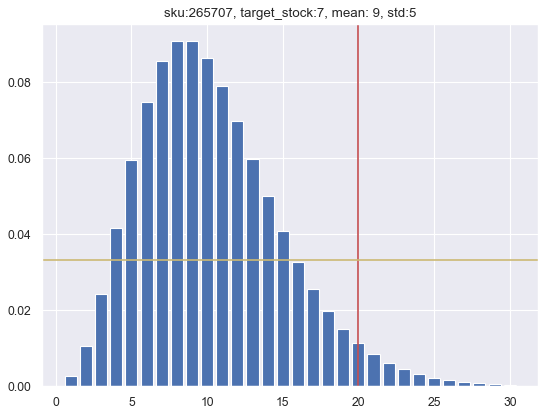

In [63]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()

idx = np.argwhere(target_series.index == sku).flat[0]
distro_hat = zinb_preds[idx,]

mean_to_stockout = (np.arange(DAYS_TO_PREDICT)*distro_hat).sum()
std_to_stockout = np.sqrt(((np.arange(DAYS_TO_PREDICT)-mean_to_stockout)**2 *distro_hat).sum())

plt.bar(range(1,31), distro_hat)
plt.axvline(days, color='r')
plt.title('sku:{}, target_stock:{}, mean: {}, std:{}'.format(int(sku), 
                                                             stock,
                                                             round(mean_to_stockout), 
                                                             round(std_to_stockout)))
plt.axhline(1/30, color='y')
plt.show()

In [64]:
# comparing other two models for this 3 categories
print("Mean RPS scores for different categories, based on ZI-NB model")
print("Model\t\tUnif\t\tNB\t\tZI-NB\t\tTotal")
print("-"*70)
for score_distro, name in zip([uniform_score_distro, linear_std_score_distro, zinb_score_distro], 
                              ["Unif", "Linear", "ZI-NB"]):
    unif = score_distro[unif_skus].mean()
    nb = score_distro[nb_skus].mean()
    zinb = score_distro[zinb_skus].mean()
    total = score_distro.mean()
    print(f"{name}\t\t{unif:.4f}\t\t{nb:.4f}\t\t{zinb:.4f}\t\t{total:.4f}")
print("-"*70)
print(f"[Sizes]\t\t{unif_skus.sum()}\t\t{nb_skus.sum()}\t\t{zinb_skus.sum()}")
print(f"[Proportions]\t{unif_skus.mean():.4f}\t\t{nb_skus.mean():.4f}\t\t{zinb_skus.mean():.4f}")

Mean RPS scores for different categories, based on ZI-NB model
Model		Unif		NB		ZI-NB		Total
----------------------------------------------------------------------
Unif		4.7649		5.0075		4.9124		4.8661
Linear		4.7517		3.9672		4.6332		4.5274
ZI-NB		4.7653		4.8119		4.9262		4.8228
----------------------------------------------------------------------
[Sizes]		271326		139926		165531
[Proportions]	0.4704		0.2426		0.2870


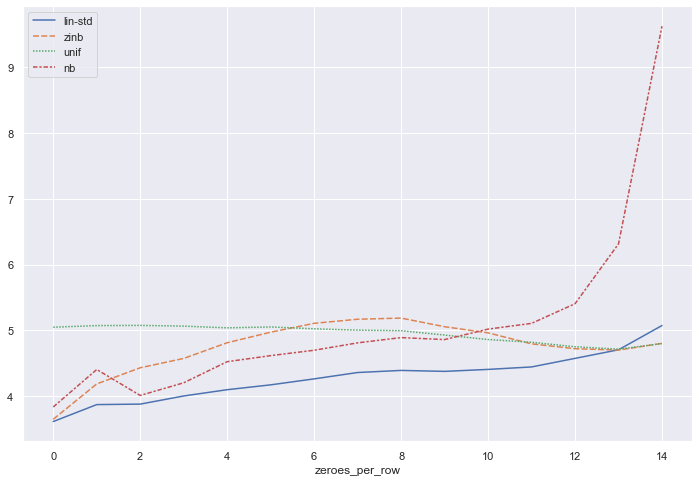

In [65]:
distros_df = pd.DataFrame({'zeroes_per_row': zeroes_per_row,
                  'lin-std':linear_std_score_distro,
                  'zinb':zinb_score_distro,
                  'unif':uniform_score_distro,
                  'nb':nb_score_distro
                 })
_ = distros_df.groupby('zeroes_per_row').mean()

fig, ax = plt.subplots(figsize=(12,8))

x = _.index.to_numpy()
sns.lineplot(data=_)
plt.show()

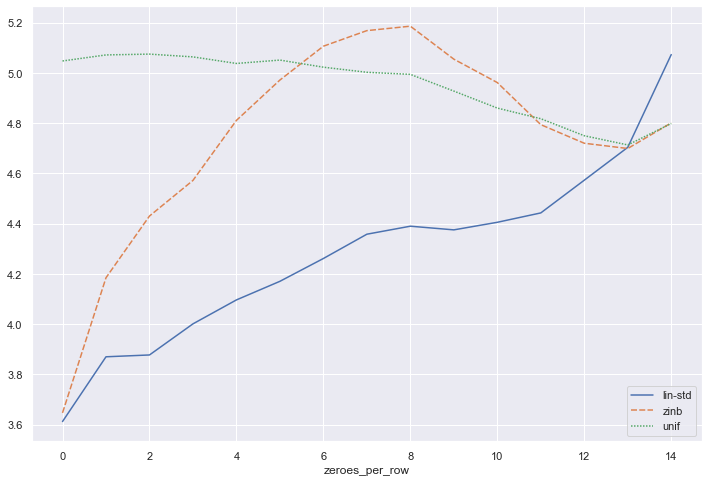

In [66]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=_.drop("nb",axis=1))
plt.show()

* The linear model is the clear winner, specially where rows are not dominated by 0s *('NB' region)*
* All models perform pretty much the same in the "invalid cases" region *('unif')*; this is understandable for ZI-NB vs Unif since they are the same, but the linear model never used the uniform distro as seen before (model.uniforms == 0)
* The Bernoulli-process approach (NB, ZI-NB) was a failure, funnily enough it does best on non-0 rows (doing well on the higher end of 0-per-row is defaulting to the uniform model), could be a problem with $p_0$ estimation

Trying with a linear model whose variance (instead of standard deviation) scales linearly with predicted days to stockout.

<AxesSubplot:ylabel='Count'>

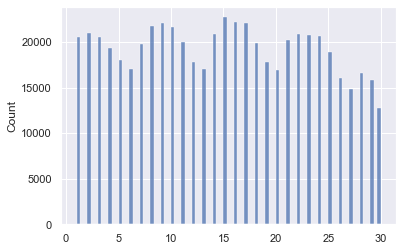

In [67]:
target_days = np.array([x['inventory_days'] for x in val_dataset])
sns.histplot(target_days)

In [68]:
# How well does a model perform for different inventory days?
print("Mean RPS scores for different target inventory day intervals")
print("Model\t\tW1\t\tW2\t\tW3\t\tW4\t\tTotal")
print("-"*80)
for score_distro, name in zip([uniform_score_distro, linear_std_score_distro, zinb_score_distro], 
                              ["Unif", "Linear", "ZI-NB"]):
    w1 = score_distro[target_days < 8].mean()
    w2 = score_distro[(target_days >= 8) & (target_days < 15)].mean()
    w3 = score_distro[(target_days >= 15) & (target_days < 22)].mean()
    w4 = score_distro[target_days >= 22].mean()
    total = score_distro.mean()
    print(f"{name}\t\t{w1:.4f}\t\t{w2:.4f}\t\t{w3:.4f}\t\t{w4:.4f}\t\t{total:.4f}")

Mean RPS scores for different target inventory day intervals
Model		W1		W2		W3		W4		Total
--------------------------------------------------------------------------------
Unif		7.1222		3.3506		2.8162		6.1198		4.8661
Linear		4.0158		3.1180		3.3934		7.2591		4.5274
ZI-NB		4.8743		4.3120		3.8931		6.0753		4.8228


Note that with the linear model converging to uniform for high predicted-mean values, a higher error in the last week indicates instead that the model is, on the contrary, predicting less inventory days than it should.

In [69]:
%%time
@load_or_exec("data/linear_scale_on_var.joblib",save_f=joblib.dump, load_f=joblib.load)
def train_linear_var():
    return LinearModelNP(global_mu=global_mu, 
                         global_std=global_std,
                         last_n_days=14, 
                         normalize=True, 
                         variance_scales=True).fit(X_train_aligned_no_stock)

linear_var_model = train_linear_var()

CPU times: total: 15.6 ms
Wall time: 11 ms


In [70]:
%%time
@load_or_exec("predictions/linear_on_var.joblib",save_f=joblib.dump, load_f=joblib.load)
def make_linear_var_predictions():
    return linear_var_model.predict(target_series)

linear_var_preds = make_linear_var_predictions()

CPU times: total: 125 ms
Wall time: 115 ms


In [71]:
linear_var_score_distro = rps_distro(linear_var_preds)
print('Normal(Var) model got a validation RPS of: ',linear_var_score_distro.mean())

Normal(Var) model got a validation RPS of:  4.788456960838676


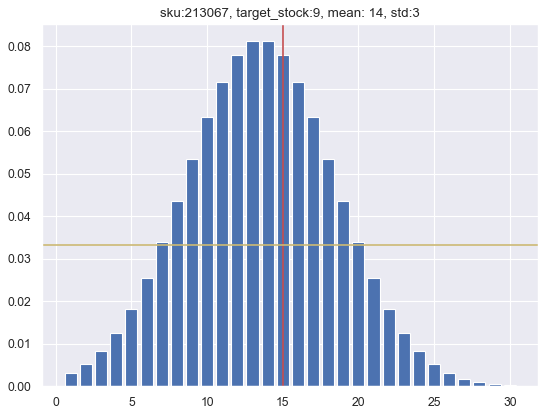

In [72]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()

idx = np.argwhere(target_series.index == sku).flat[0]
distro_hat = linear_var_preds[idx,]

mean_to_stockout = stock / linear_var_model.means[idx]
std_to_stockout = linear_var_model.stds[idx] * np.sqrt(mean_to_stockout)

plt.bar(range(1,31), distro_hat)
plt.axvline(days, color='r')
plt.title('sku:{}, target_stock:{}, mean: {}, std:{}'.format(int(sku), 
                                                             stock,
                                                             round(mean_to_stockout), 
                                                             round(std_to_stockout)))
plt.axhline(1/30, color='y')
plt.show()

In [73]:
# How well does a model perform for different inventory days?
print("Mean RPS scores for different target inventory day intervals")
print("Model\t\tW1\t\tW2\t\tW3\t\tW4\t\tTotal")
print("-"*80)
for score_distro, name in zip([uniform_score_distro, linear_std_score_distro, zinb_score_distro, linear_var_score_distro], 
                              ["Unif", "Lin-std", "ZI-NB", "Lin-var"]):
    w1 = score_distro[target_days < 8].mean()
    w2 = score_distro[(target_days >= 8) & (target_days < 15)].mean()
    w3 = score_distro[(target_days >= 15) & (target_days < 22)].mean()
    w4 = score_distro[target_days >= 22].mean()
    total = score_distro.mean()
    print(f"{name}\t\t{w1:.4f}\t\t{w2:.4f}\t\t{w3:.4f}\t\t{w4:.4f}\t\t{total:.4f}")

Mean RPS scores for different target inventory day intervals
Model		W1		W2		W3		W4		Total
--------------------------------------------------------------------------------
Unif		7.1222		3.3506		2.8162		6.1198		4.8661
Lin-std		4.0158		3.1180		3.3934		7.2591		4.5274
ZI-NB		4.8743		4.3120		3.8931		6.0753		4.8228
Lin-var		3.8558		4.2222		4.1628		6.6697		4.7885


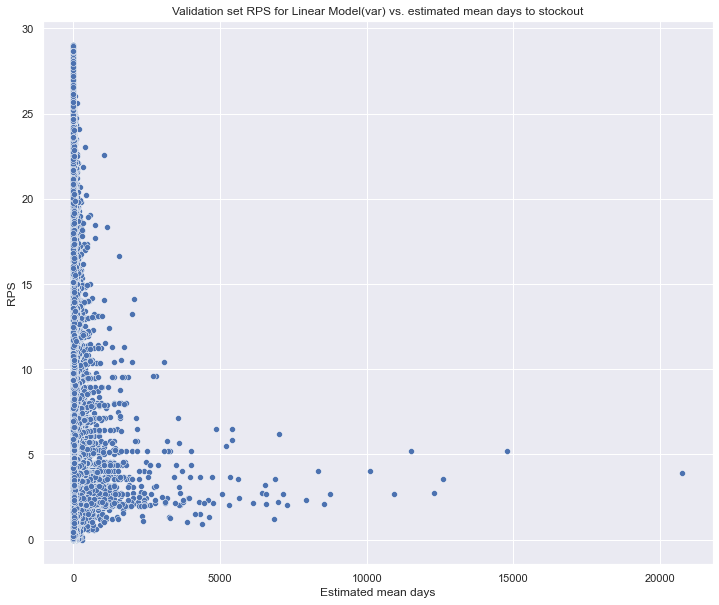

In [74]:
plot_RPS_vs_estimated_mean(linear_var_model.predict_mu_sigma(target_series)[0], linear_var_score_distro,"Linear Model(var)")

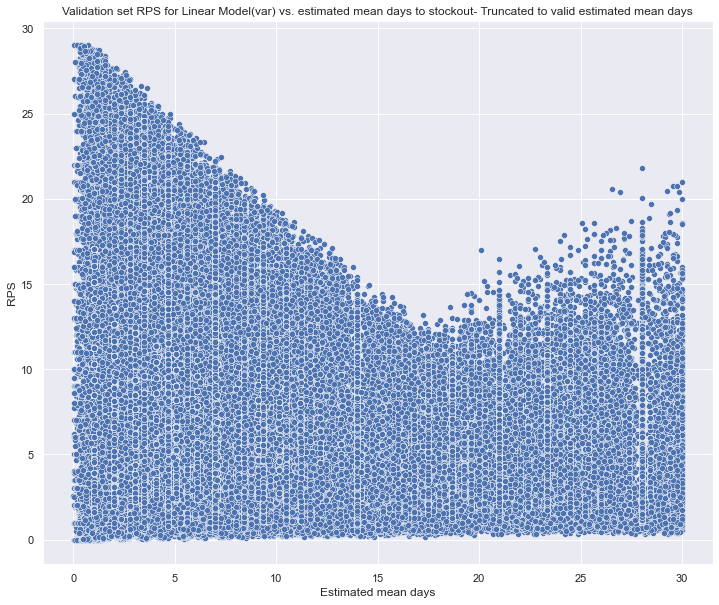

In [75]:
plot_RPS_vs_estimated_mean(linear_var_model.predict_mu_sigma(target_series)[0], 
                           linear_var_score_distro,"Linear Model(var)",truncate_to_valid=True)

As can be seen, this is strictly worse than the first normal model.

Now that we're done with "common" models (Poisson is no-go given huge overdispersion), we can ask ourselves is the metric $\frac{target\_stock}{nanmean(row)}$ meaningful at all? Assuming we'll be getting DivideByZero errors or even just values outside of valid range \[\[1;30\]\], is clipping an option?

In [76]:
def normalized_estimated_days(target_stocks, X):
    nan_mean_capped = np.nanmean(X,axis=1)
    
    # avoid DivideByZero
    nan_mean_capped[nan_mean_capped == 0] = np.nan
    
    # divide
    if type(target_stocks)==pd.Series:
        target_stocks =  target_stocks.to_numpy()
    normalized_estimated_days = target_stocks / nan_mean_capped
    
    # replace nans with max value(30), do it inplace
    np.nan_to_num(normalized_estimated_days, nan=30.0, copy=False)

    return normalized_estimated_days

# now inplace replace NaNs with the maximum value available: 30
normalized_estimated_days14 = normalized_estimated_days(target_series, train_data)
normalized_estimated_days_full = normalized_estimated_days(target_series, X_train_aligned_no_stock)

C:\Users\martinn\AppData\Local\Temp\ipykernel_12916\2385653882.py:2: RuntimeWarning: Mean of empty slice
  nan_mean_capped = np.nanmean(X,axis=1)


In [77]:
print(np.mean(normalized_estimated_days14 > 30), np.mean(normalized_estimated_days_full > 30))

0.20883070409495424 0.24880067547067095


In [78]:
print(np.max(normalized_estimated_days14), np.max(normalized_estimated_days_full))

20748.0 29812.0


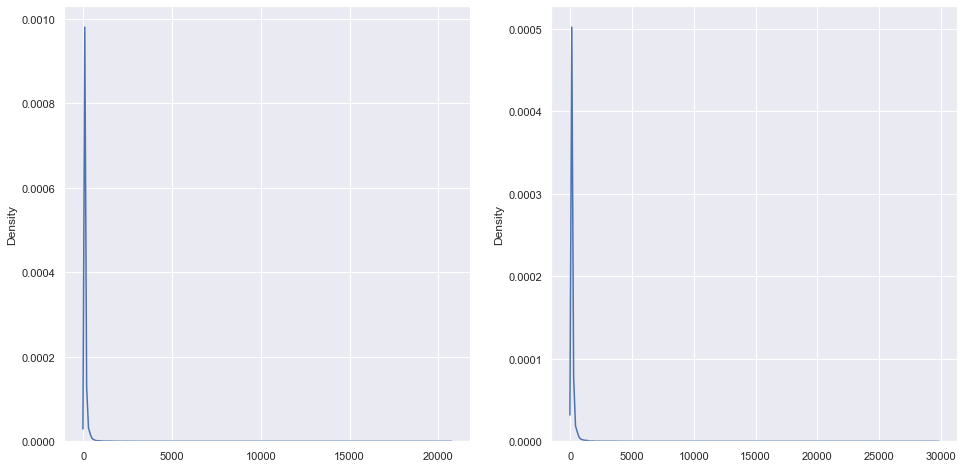

In [79]:
# here we're just getting confirmation that there're extreme values
fig, [ax1, ax2] = plt.subplots(figsize=(16,8),ncols=2,nrows=1)
sns.kdeplot(normalized_estimated_days14, ax=ax1)
sns.kdeplot(normalized_estimated_days_full, ax=ax2)
plt.show()

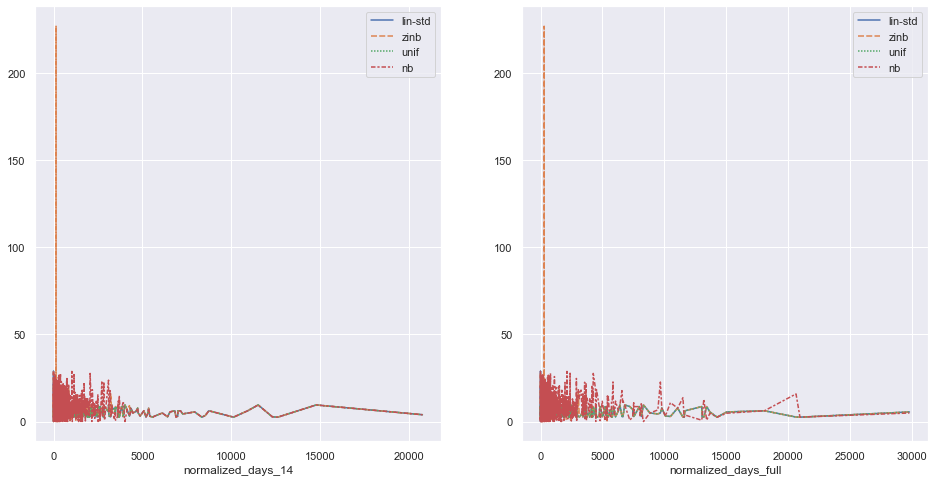

In [80]:
fig, [ax1, ax2] = plt.subplots(figsize=(16,8),ncols=2,nrows=1)

distros_df["normalized_days_14"] = normalized_estimated_days14
distros_df["normalized_days_full"] = normalized_estimated_days_full

rps_by_days_14 = distros_df.drop(columns=['zeroes_per_row','normalized_days_full']).groupby('normalized_days_14').mean()
rps_by_days_full =distros_df.drop(columns=['zeroes_per_row','normalized_days_14']).groupby('normalized_days_full').mean()

sns.lineplot(data=rps_by_days_14,ax=ax1)
sns.lineplot(data=rps_by_days_full,ax=ax2)
plt.show()

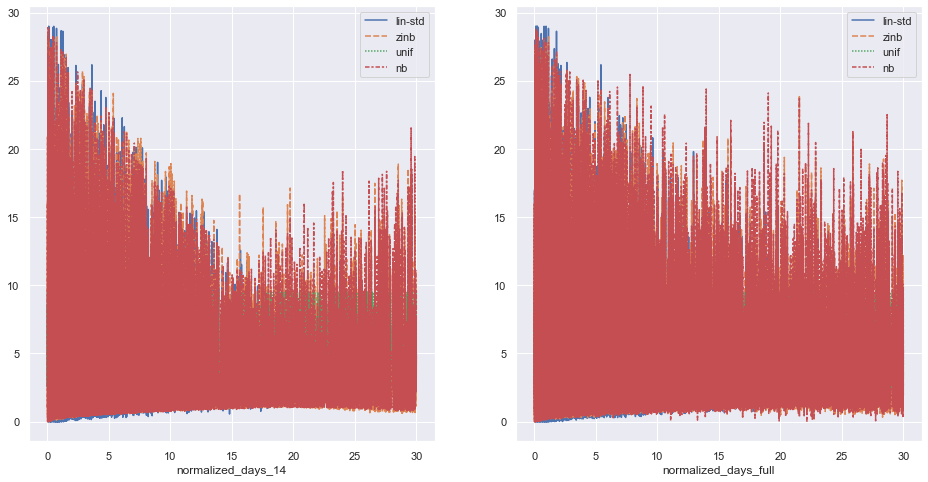

In [81]:
# first truncate, not clip
rps_by_days_14_truncated = rps_by_days_14[rps_by_days_14.index <= 30]
rps_by_days_full_truncated = rps_by_days_full[rps_by_days_full.index <=30]

fig, [ax1, ax2] = plt.subplots(figsize=(16,8),ncols=2,nrows=1)
sns.lineplot(data=rps_by_days_14_truncated,ax=ax1)
sns.lineplot(data=rps_by_days_full_truncated,ax=ax2)
plt.show()

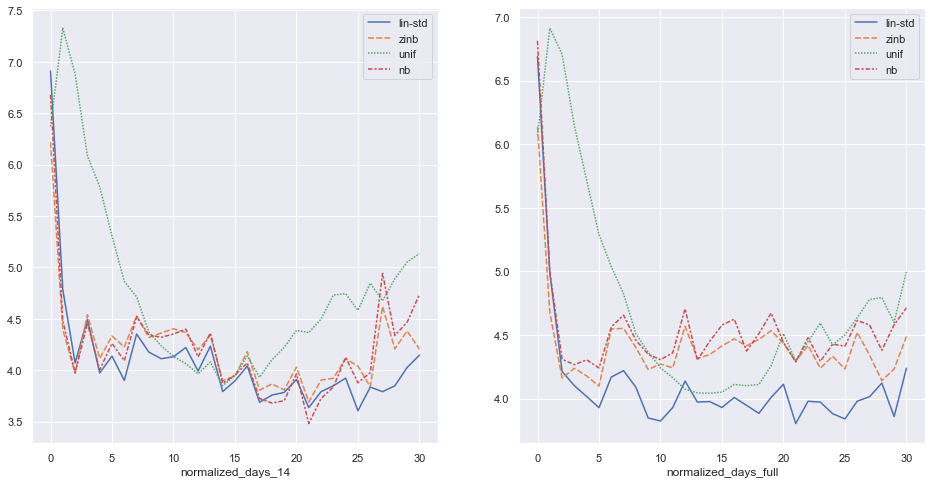

In [82]:
# round estimated days, this is TOO noisy
def index_to_int(df):
    new_idx = df.index.to_series().round()
    return df.groupby(new_idx).mean()

rps_by_days_14_truncated_rounded = index_to_int(rps_by_days_14_truncated)
rps_by_days_full_truncated_rounded = index_to_int(rps_by_days_full_truncated)

fig, [ax1, ax2] = plt.subplots(figsize=(16,8),ncols=2,nrows=1)
sns.lineplot(data=rps_by_days_14_truncated_rounded,ax=ax1)
sns.lineplot(data=rps_by_days_full_truncated_rounded,ax=ax2)
plt.show()

Now **this** is informative, but indirectly:
* Obviously the nanmean over the days used for training is a better predictor of performance than all the days. Although, it's not terrible. There seem to be shifts in the distribution but not too big.
* Given valid values of *normalized\_estimated\_days* all Normal and Bernoulli-based models do pretty well. It may be interesting to compare their performance in this context, even if we know the gaussian model is the best.
* There may be some gain in building a model specifically targetting low estimated days (3-12)
* Extremes behave badly, specially the ones near the 0

For estimated\_days >30 we expect uniform to do best (or near)

In [83]:
# stable-estimated_days values
print(rps_by_days_14_truncated.agg('mean'))

lin-std    4.182741
zinb       4.272907
unif       4.926143
nb         4.263027
dtype: float64


In [84]:
# exclude special cases 0 and 1
print(rps_by_days_14_truncated[rps_by_days_14_truncated.index > 1].agg('mean'))

lin-std    4.020579
zinb       4.164887
unif       4.781701
nb         4.128280
dtype: float64


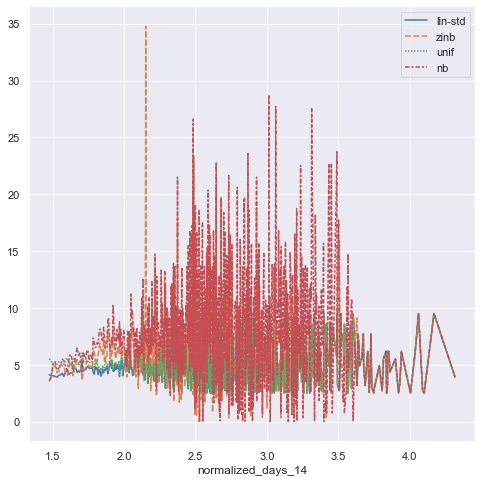

In [85]:
# plot the same RPS-by-estimated_day but x uses log-scale because of long tail
__ = index_to_int(rps_by_days_14[rps_by_days_14.index > 30])
__.set_index(np.log10(__.index),inplace=True)

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=__)
plt.show()

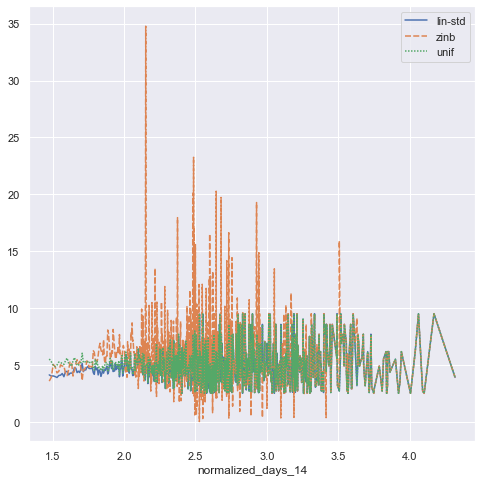

In [86]:
# NB is WAY too noisy
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=__.drop(columns=['nb']))
plt.show()

In [87]:
# sometimes less is more...
print(__.mean())

lin-std    4.918579
zinb       5.696337
unif       4.991542
nb         7.885017
dtype: float64


Basically, both extremes are filled with low-information rows. Given how stable uniform distribution is for the >30 cases, it makes sense to now focus on the 0 and 1 estimated-day cases. For this, it's important to remember that all previous models were based on the estimation of the mean, which seems to be over-estimated for the extreme cases of 0 and 1.
On this there are some options:
* Post-fit processing: clip estimated means
* Outlier identifications/robust centrality measure aka median for high estimated-days rows
* Add a prior bias
* Use EWMAs to account for shifts in distribution
* Calculate multiple centrality measures (mean, median, EWMAs) and use the central one/mean of them

In [88]:
# clipped lin-std model
def predict_clipped_mu_sigma(self, target_stocks):
    # WARNING: it is ASSUMED that the train data and target_stocks are SKU-aligned
    days_to_stockout = target_stocks.to_numpy() / self.means
        
    # CLIP days_to_stockout inplace
    np.clip(days_to_stockout, a_min=1, a_max=30, out=days_to_stockout)
    
    # which one scales linearly with days, std or variance?
    if self.variance_scales:
        scaler = np.sqrt(days_to_stockout)  # variance scales linearly
    else:
        scaler = days_to_stockout           # std scales linearly
        
    std_days = self.stds / self.means * scaler
        
    return days_to_stockout, std_days

# abuse @load_or_exec mechanics for a fresh copy
clipped_linear_std_model = train_linear_std() 

# override predict mu method with clipped variant
clipped_linear_std_model.predict_mu_sigma = partial(predict_clipped_mu_sigma, clipped_linear_std_model) 

In [89]:
# test it
clipped_days, clipped_stds = clipped_linear_std_model.predict_mu_sigma(target_series)
clipped_days.min(), clipped_days.max()

(1.0, 30.0)

In [90]:
%%time
@load_or_exec("predictions/clipped_linear_on_std.joblib",save_f=joblib.dump, load_f=joblib.load)
def make_clipped_linear_std_predictions():
    return clipped_linear_std_model.predict(target_series)

clipped_linear_std_preds = make_clipped_linear_std_predictions()

CPU times: total: 125 ms
Wall time: 127 ms


In [91]:
clipped_linear_std_score_distro = rps_distro(clipped_linear_std_preds)
print('Clipped normal model got a validation RPS of: ',clipped_linear_std_score_distro.mean())

Clipped normal model got a validation RPS of:  4.5199009863292074


In [92]:
(clipped_linear_std_score_distro[normalized_estimated_days14 > 30].mean(), 
 linear_std_score_distro[normalized_estimated_days14 > 30].mean())

(4.309155798398015, 4.325786536685099)

In [93]:
(clipped_linear_std_score_distro[normalized_estimated_days14 < 2].mean(), 
 linear_std_score_distro[normalized_estimated_days14 < 2].mean())

(5.198883260108917, 5.309712129965165)

While there is some improvement, it's not significant. It would seem like these series just don't behave like the others.

In [94]:
# the mother of all residual plots
target_days_by_estimated_days = pd.DataFrame({
    'target':target_days,
    'estimated':np.minimum(normalized_estimated_days14.round().astype(int), 31) # use 31 for '>30' flag
})

# count occurrences
hm_target_vs_estimated_days = target_days_by_estimated_days.pivot_table(index='estimated', 
                                                                        columns='target', 
                                                                        aggfunc=len, #count 
                                                                        fill_value=0)
# make them percentage fraction
hm_target_vs_estimated_days_perc_fraction =  (hm_target_vs_estimated_days / target_days_by_estimated_days.size * 100).round(3)
hm_target_vs_estimated_days_perc_fraction

target        1      2      3      4      5      6      7      8      9   \
estimated                                                                  
0          0.057  0.024  0.017  0.013  0.008  0.004  0.005  0.007  0.009   
1          0.313  0.148  0.084  0.052  0.039  0.026  0.028  0.024  0.023   
2          0.339  0.258  0.160  0.103  0.068  0.051  0.050  0.050  0.037   
3          0.161  0.178  0.140  0.099  0.073  0.057  0.049  0.044  0.039   
4          0.178  0.197  0.181  0.148  0.106  0.084  0.081  0.069  0.062   
5          0.158  0.174  0.158  0.139  0.119  0.088  0.093  0.081  0.071   
6          0.046  0.084  0.102  0.100  0.093  0.077  0.081  0.077  0.065   
7          0.154  0.156  0.151  0.144  0.127  0.115  0.116  0.115  0.101   
8          0.014  0.038  0.055  0.067  0.063  0.064  0.072  0.075  0.071   
9          0.036  0.062  0.082  0.078  0.078  0.074  0.088  0.090  0.085   
10         0.010  0.030  0.043  0.047  0.054  0.056  0.067  0.072  0.067   
11         0.005  0.014  0.024  0.028  0.031  0.032  0.040  0.046  0.042   
12         0.005  0.011  0.019  0.024  0.029  0.030  0.043  0.045  0.046   
13         0.001  0.003  0.005  0.010  0.011  0.012  0.019  0.022  0.025   
14         0.131  0.150  0.160  0.155  0.138  0.138  0.151  0.162  0.166   
15         0.001  0.002  0.003  0.004  0.007  0.008  0.012  0.015  0.017   
16         0.001  0.005  0.009  0.012  0.011  0.014  0.020  0.028  0.027   
17         0.002  0.004  0.006  0.008  0.011  0.012  0.015  0.019  0.024   
18         0.002  0.006  0.012  0.012  0.015  0.018  0.024  0.030  0.035   
19         0.003  0.009  0.015  0.016  0.019  0.024  0.027  0.040  0.038   
20         0.001  0.003  0.004  0.006  0.008  0.011  0.012  0.017  0.019   
21         0.008  0.020  0.029  0.034  0.039  0.036  0.045  0.057  0.052   
22         0.001  0.001  0.004  0.005  0.005  0.006  0.009  0.013  0.015   
23         0.001  0.004  0.006  0.011  0.014  0.013  0.018  0.026  0.027   
24         0.001  0.002  0.003  0.006  0.007  0.007  0.011  0.013  0.015   
25         0.000  0.001  0.001  0.003  0.002  0.004  0.005  0.006  0.009   
26         0.000  0.001  0.002  0.001  0.003  0.004  0.007  0.008  0.010   
27         0.000  0.000  0.001  0.001  0.001  0.001  0.002  0.003  0.004   
28         0.024  0.044  0.054  0.061  0.058  0.057  0.070  0.075  0.083   
29         0.000  0.000  0.000  0.001  0.001  0.001  0.002  0.002  0.003   
30         0.110  0.147  0.172  0.185  0.200  0.207  0.253  0.296  0.329   
31         0.017  0.048  0.081  0.105  0.123  0.146  0.204  0.259  0.298   

target        10  ...     21     22     23     24     25     26     27     28  \
estimated         ...                                                           
0          0.007  ...  0.002  0.003  0.002  0.002  0.002  0.001  0.001  0.002   
1          0.020  ...  0.010  0.010  0.010  0.011  0.011  0.008  0.009  0.011   
2          0.030  ...  0.015  0.017  0.017  0.015  0.016  0.016  0.013  0.017   
3          0.034  ...  0.014  0.014  0.015  0.013  0.012  0.010  0.011  0.014   
4          0.046  ...  0.020  0.017  0.021  0.019  0.020  0.015  0.014  0.017   
5          0.060  ...  0.024  0.022  0.022  0.021  0.019  0.014  0.015  0.018   
6          0.057  ...  0.020  0.019  0.019  0.017  0.016  0.013  0.013  0.014   
7          0.083  ...  0.031  0.032  0.032  0.030  0.026  0.022  0.019  0.021   
8          0.060  ...  0.024  0.024  0.024  0.020  0.016  0.011  0.014  0.013   
9          0.075  ...  0.029  0.027  0.024  0.024  0.024  0.019  0.014  0.016   
10         0.068  ...  0.030  0.027  0.025  0.023  0.021  0.015  0.015  0.016   
11         0.044  ...  0.019  0.018  0.017  0.017  0.017  0.015  0.013  0.012   
12         0.046  ...  0.025  0.025  0.021  0.021  0.021  0.016  0.013  0.013   
13         0.026  ...  0.014  0.015  0.016  0.011  0.012  0.009  0.008  0.008   
14         0.161  ...  0.079  0.080  0.077  0.070  0.059  0.045  0.037  0.045   
15         0.018  ...  0.016  0.013  0

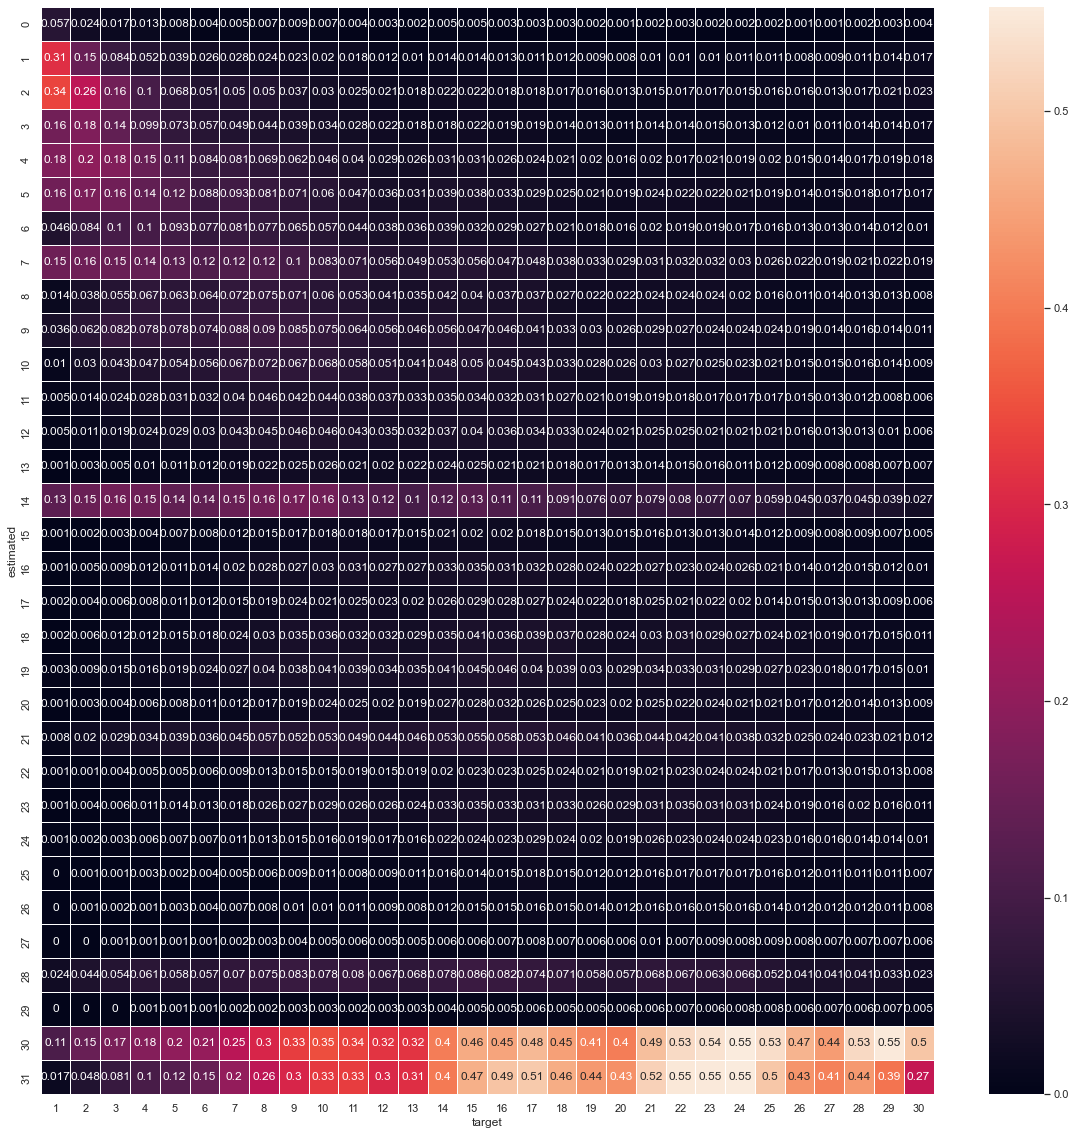

In [95]:
fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(hm_target_vs_estimated_days_perc_fraction,
            annot=True, 
            linewidths=.5)
plt.show()

* no-information rows (30, 31 estimated days) concentrate a lot of mass + they're super hard to estimate (as can be seen for 30 estimated days (original mean=0) where there's pretty much the same prob. of target being 15 or 30). A somewhat decent estimation seems to be a uniform distribution over the last 15 days, but this could change + counts as leakage
* "end-of-week" days seem to concentrate mass too (7,14,21,28)
* 0 estimated days are pretty much concentrated on the first days but after that there's a super long tail
* it may be interesting to use estimated\_days as a predictor and normalize over it to reduce the importance of last 2 rows

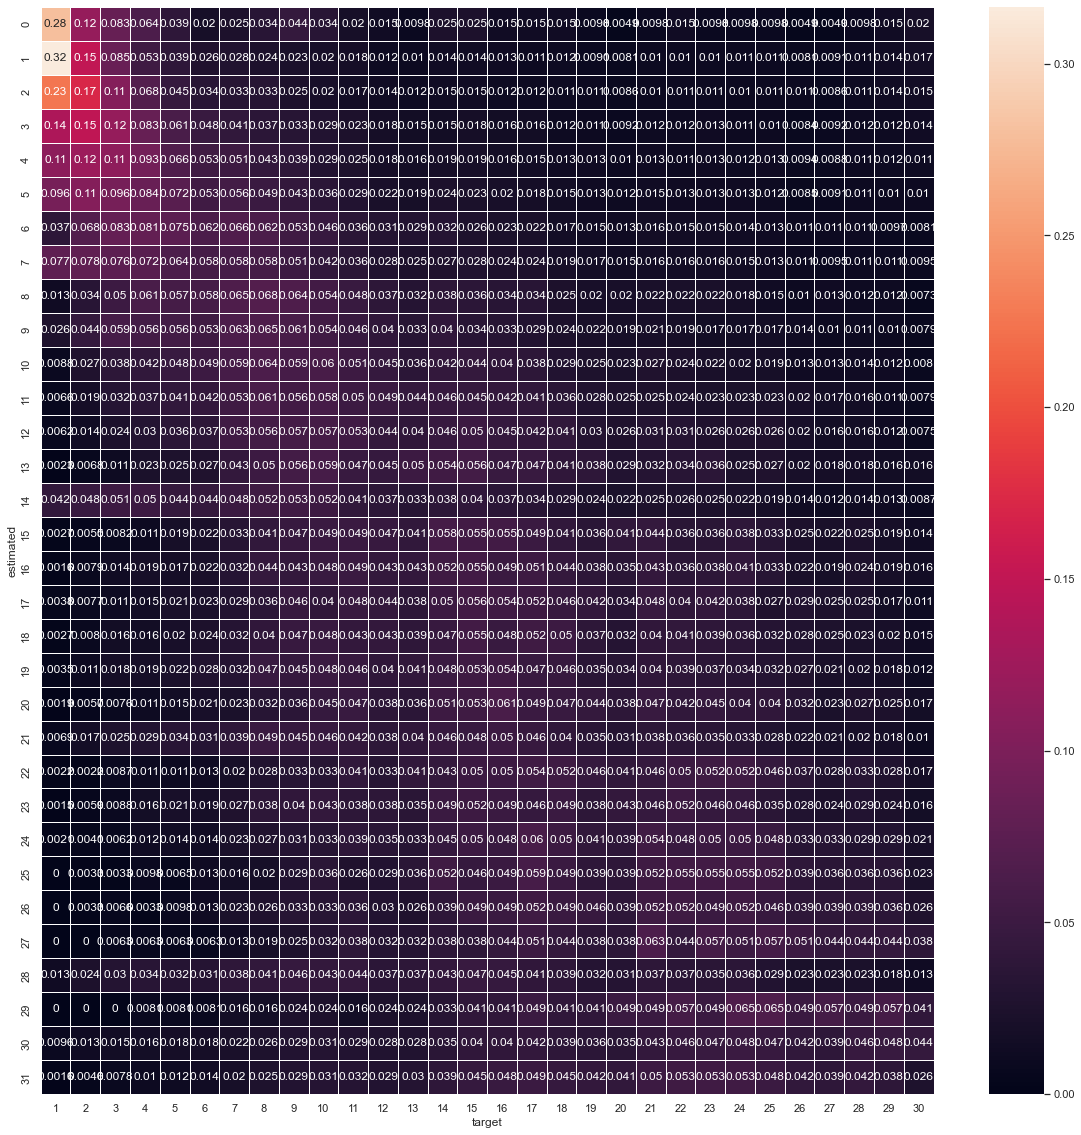

In [96]:
# normalize by row
hm_target_vs_estimated_days_perc_fraction_normalized = (
    hm_target_vs_estimated_days_perc_fraction / hm_target_vs_estimated_days_perc_fraction.sum(axis=1).to_numpy().reshape(-1,1)
)

fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(hm_target_vs_estimated_days_perc_fraction_normalized,
            annot=True, 
            linewidths=.5)
plt.show()

Now we can confirm that low estimated\_days are a strong estimator of the target, while increasing values tend to hold much higher uncertainty, even with some bias (for an estimation of 20 the distribution seems to be centered at approximately 16)

In [97]:
@njit(fastmath=True)
def EWMA(X: np.ndarray,lda: float) -> np.ndarray:
    """
    Calculate a lambda-EWMA on a matrix X, column-wise. 
    Update formula is v_t = (1-lambda)*x_t+ lambda*v_{t-1}.
    """
    cols = X.shape[1]
    
    # init as first 
    ewma = X[:,0]
        
    for i in range(1,cols):
        ewma = lda * ewma + (1-lda) * X[:,i]
    
    return ewma.flatten()

_ = np.array([[1,2,3],[1,2,3]],dtype=float)
print(_)
print(EWMA(_,0.9))

[[1. 2. 3.]
 [1. 2. 3.]]
[1.29 1.29]


Reminder that if update rule is $v_t = \lambda \cdot v_{t-1} + (1-\lambda) \cdot x_t$, the EWMA is approximately averaging over the last $n=\frac{1}{1-\lambda}$ elements of $x$, which also gives $\lambda = 1 - \frac{1}{n} = \frac{n-1}{n}$. 
For 7 and 3.5 days (1 week, half week) resulting lambda values are $\frac{6}{7} \approx 0.857, \frac{2.5}{3.5} \approx 0.7143$

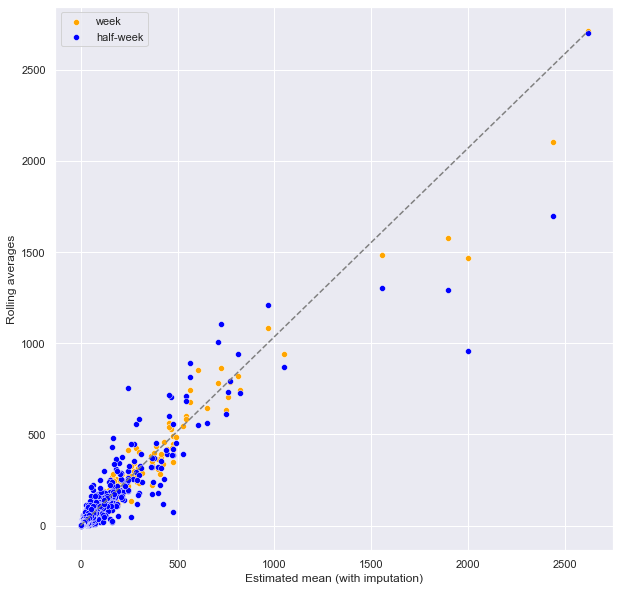

In [98]:
zero_filled_np14 = train_data.fillna(0).to_numpy()
ewma_week = EWMA(zero_filled_np14, 6/7) 
ewma_halfweek = EWMA(zero_filled_np14, 2.5/3.5)

fig, ax = plt.subplots(figsize=(10,10))
_x = linear_std_model.means
_y = np.concatenate([ewma_halfweek,ewma_week])
sns.scatterplot(y=ewma_week, x=_x, color='orange', label='week')
sns.scatterplot(y=ewma_halfweek, x=_x, color='blue', label='half-week')
ax.plot((_x.min(),_x.max()),(_y.min(),_y.max()), color='gray', linestyle='dashed')

ax.set_ylabel("Rolling averages")
ax.set_xlabel("Estimated mean (with imputation)")
ax.legend()

plt.show()

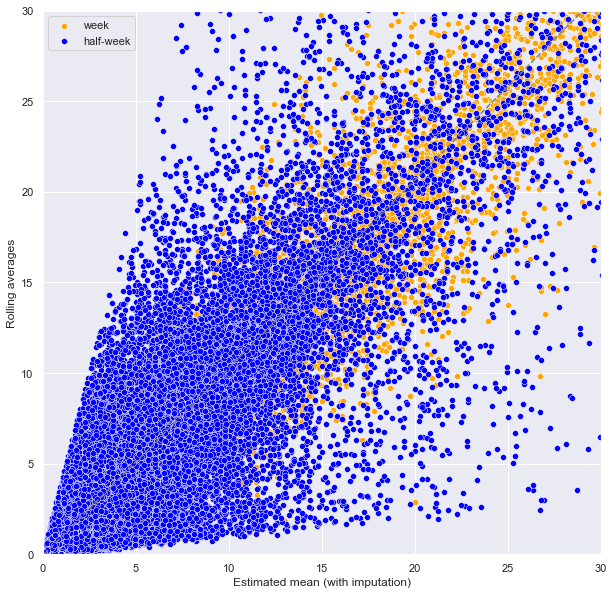

In [99]:
fig, ax = plt.subplots(figsize=(10,10))
_x = linear_std_model.means
_y = np.concatenate([ewma_halfweek,ewma_week])
sns.scatterplot(y=ewma_week, x=_x, color='orange', label='week')
sns.scatterplot(y=ewma_halfweek, x=_x, color='blue', label='half-week')
ax.plot((_x.min(),_x.max()),(_y.min(),_y.max()), color='gray', linestyle='dashed')

ax.set_ylabel("Rolling averages")
ax.set_xlabel("Estimated mean (with imputation)")
ax.legend()

ax.set_xlim(0,30)
ax.set_ylim(0,30)
plt.show()

C:\Users\martinn\.conda\envs\kaggle\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


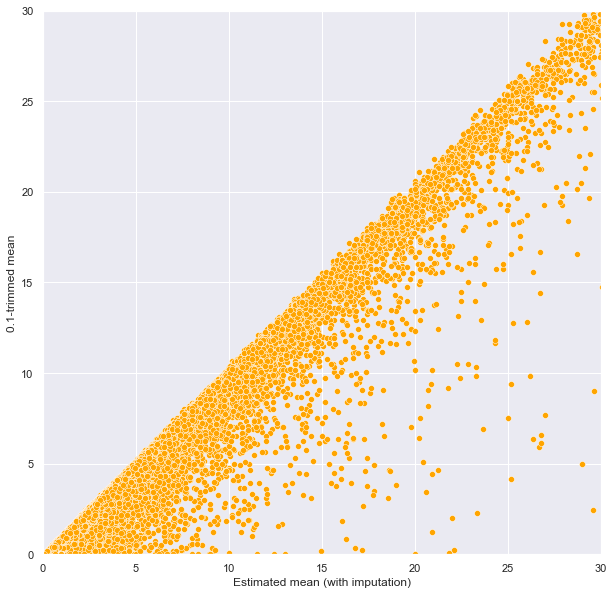

In [100]:
# more robust measures of centrality
medians= np.nan_to_num(np.nanmedian(train_data, axis=1), nan=global_mu)
trim_01_mean = stats.trim_mean(zero_filled_np14, proportiontocut=0.1, axis=1)

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(y=trim_01_mean, x=_x, color='orange')

ax.plot((0,0),(30,30), color='gray', linestyle='dashed')

ax.set_ylabel("0.1-trimmed mean")
ax.set_xlabel("Estimated mean (with imputation)")

ax.set_xlim(0,30)
ax.set_ylim(0,30)
plt.show()

The trimmed mean looked nice, although sometimes it seems to force 0s on rows plagued by those. Will now fit a linear model using two strategies: mean and median of (mean, median, 0.1-trimmed mean, EWMA-week, EWMA-halfweek).
* The mean strategy is aimed at a more efficient (in statistical terms) policy, letting all weak estimators provide a measure
* The median strategy is aimed at a more conservative/robust policy where the mean and EWMAs may be suspected of providing over-estimations (hence this will probably be the minimum between those 3)

It should be noted that while EWMAs seem to be immune to 0-heavy rows, trimmed mean and median will have excess 0s. This is accounted for in the median where all-nans are replaced with global mean, in an effort to make the median positive without distorting the metric too much.

In [101]:
df_centralities = pd.DataFrame({
    'mean': linear_std_model.means,
    'median': medians,
    'trimmed-mean': trim_01_mean,
    'ewma-week': ewma_week,
    'ewma-halfweek': ewma_halfweek
})

df_centralities.head()

mean  median  trimmed-mean  ewma-week  ewma-halfweek
0  0.986099     0.0      0.000000   0.000000       0.000000
1  0.500000     0.0      0.416667   0.601095       0.847301
2  0.214286     0.0      0.166667   0.110447       0.047988
3  1.500000     1.0      0.750000   1.421275       1.318083
4  0.071429     0.0      0.000000   0.142857       0.285714

In [102]:
df_centralities.describe()

mean         median   trimmed-mean      ewma-week  \
count  576783.000000  576783.000000  576783.000000  576783.000000   
mean        1.217402       0.627051       0.843174       1.006456   
std         8.930430       7.893965       8.455969       8.648800   
min         0.071429       0.000000       0.000000       0.000000   
25%         0.285714       0.000000       0.000000       0.048560   
50%         0.642857       0.000000       0.166667       0.285580   
75%         0.986099       0.000000       0.583333       0.730985   
max      2616.000000    2515.000000    2638.500000    2710.700835   

       ewma-halfweek  
count  576783.000000  
mean        1.025967  
std         8.608984  
min         0.000000  
25%         0.013829  
50%         0.250546  
75%         0.743857  
max      2700.953803

In [103]:
mat_centralities = df_centralities.to_numpy()

mean_of_centralities = mat_centralities.mean(axis=1)
median_of_centralities = np.median(mat_centralities, axis=1)

In [104]:
# are these better measures than the linear_std, global_average-imputed mean? one way to know: MAE, MSE

from sklearn.metrics import mean_absolute_error, mean_squared_error

for mean_pred, name in zip([linear_std_model.means, mean_of_centralities, median_of_centralities], 
                        ['Lin-std mean', 'mean of mixture', 'median of mixture']):
    MAE = mean_absolute_error(target_days, mean_pred)
    MSE = mean_squared_error(target_days, mean_pred)
    print(f"{name} metric has \t {MSE:.3f} MSE\t{MAE:.3f} MAE")

Lin-std mean metric has 	 339.904 MSE	14.243 MAE
mean of mixture metric has 	 339.165 MSE	14.484 MAE
median of mixture metric has 	 342.759 MSE	14.517 MAE


In [105]:
# build a lin-std model with this for a marginal gain
mean_mixture_lin_std_model = train_linear_std()

mean_mixture_lin_std_model.means = mean_of_centralities

In [106]:
%%time
@load_or_exec("predictions/mean_mixture_linear_on_std.joblib",save_f=joblib.dump, load_f=joblib.load)
def make_mean_mixture_linear_std_predictions():
    return mean_mixture_lin_std_model.predict(target_series)

mean_mixture_lin_std_preds = make_mean_mixture_linear_std_predictions()

CPU times: total: 125 ms
Wall time: 125 ms


In [107]:
mean_mixture_lin_std_score_distro = rps_distro(mean_mixture_lin_std_preds)
print('Mean-mixture Lin-std model got a validation RPS of: ',mean_mixture_lin_std_score_distro.mean())

Mean-mixture Lin-std model got a validation RPS of:  4.45263321088523


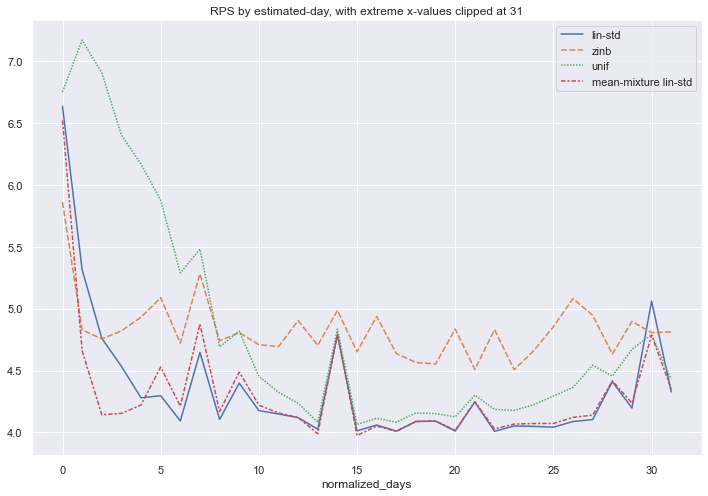

In [108]:
distros_df['mean-mixture lin-std'] = mean_mixture_lin_std_score_distro

def plot_distros_df(df,policy=None,value=None, exclude=[], mask=None):
    df = df.copy()
    df['normalized_days'] = df['normalized_days_14'].round()
    df.drop(columns=['zeroes_per_row','normalized_days_full','normalized_days_14']+exclude, inplace=True)
    if policy is not None:
        if policy=='clip':
            df['normalized_days'] = np.minimum(df['normalized_days'], value)
        if policy=='truncate':
            df = df[df['normalized_days'] <= value]
    if mask is not None:
        df = df[mask]
    grouped_df = df.groupby('normalized_days').mean()
    fig, ax = plt.subplots(figsize=(12,8))
    sns.lineplot(data=grouped_df,ax=ax)
    return ax
    
ax = plot_distros_df(distros_df, policy='clip', value=31, exclude=['nb'])
ax.set_title("RPS by estimated-day, with extreme x-values clipped at 31")
plt.show()

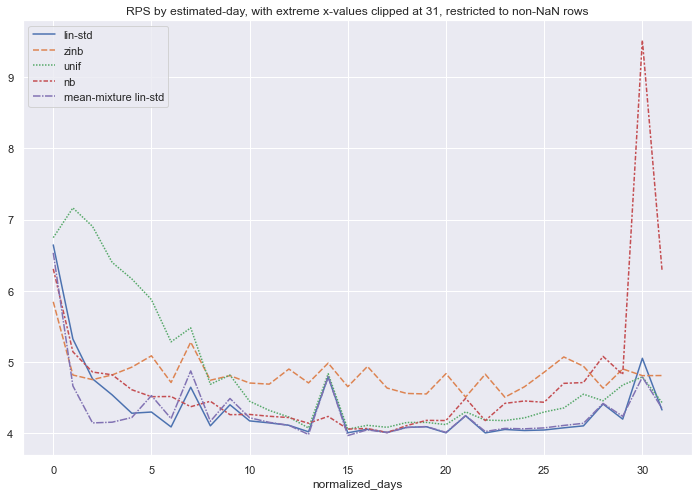

In [109]:
non_nan_rows = (train_data.isna().sum(axis=1) == 0).to_numpy()
ax = plot_distros_df(distros_df, policy='clip', value=31, 
                     mask=non_nan_rows) # only consider rows with 0 NaN values
ax.set_title("RPS by estimated-day, with extreme x-values clipped at 31, restricted to non-NaN rows")
plt.show()

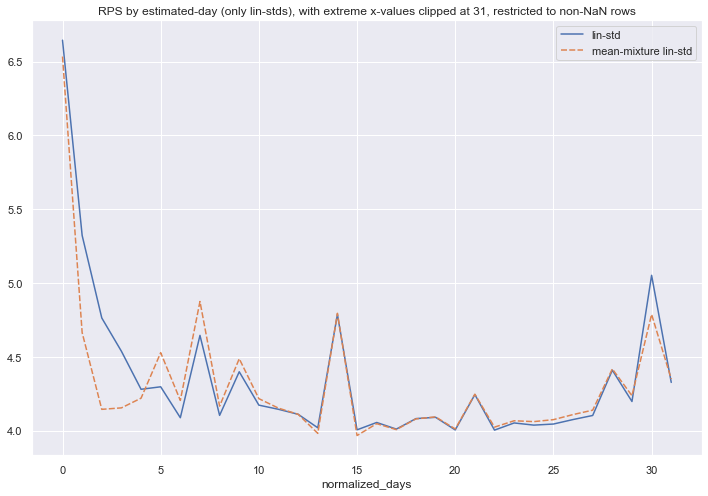

In [110]:
ax = plot_distros_df(distros_df, policy='clip', value=31, exclude=['nb','zinb','unif'],
                     mask=non_nan_rows) # only consider rows with 0 NaN values
ax.set_title("RPS by estimated-day (only lin-stds), with extreme x-values clipped at 31, restricted to non-NaN rows")
plt.show()

In [111]:
# one last chance for bernoulli-based models
nb_zinb_coef = np.clip(normalized_estimated_days14, a_max=31, a_min=0) / 31
nb_zinb_coef = nb_zinb_coef.reshape(-1,1)

# estimated_days-weighted linear combination of NB and ZI-NB, where more days means NB -> ZI-NB
nb_zinb_linear_comb_preds = nb_zinb_coef * zinb_preds + (1-nb_zinb_coef)*nb_preds

nb_zinb_linear_comb_score_distro = rps_distro(nb_zinb_linear_comb_preds)
print('Linear-comb of NB models got a validation RPS of: ',nb_zinb_linear_comb_score_distro.mean())

Linear-comb of NB models got a validation RPS of:  4.616932404629913


In [112]:
# what if: NB and mean-mixture lin-std?
# estimated_days-weighted linear combination of NB and Gaussian, where more days means NB -> Mean-mixture Gaussian
nb_gaussian_preds = nb_zinb_coef * mean_mixture_lin_std_preds + (1-nb_zinb_coef)*nb_preds

nb_gaussian_score_distro = rps_distro(nb_gaussian_preds)
print('Linear-comb of NB and mean-of-mixture Gaussian models got a validation RPS of: ',nb_gaussian_score_distro.mean())

Linear-comb of NB and mean-of-mixture Gaussian models got a validation RPS of:  4.405570438935999


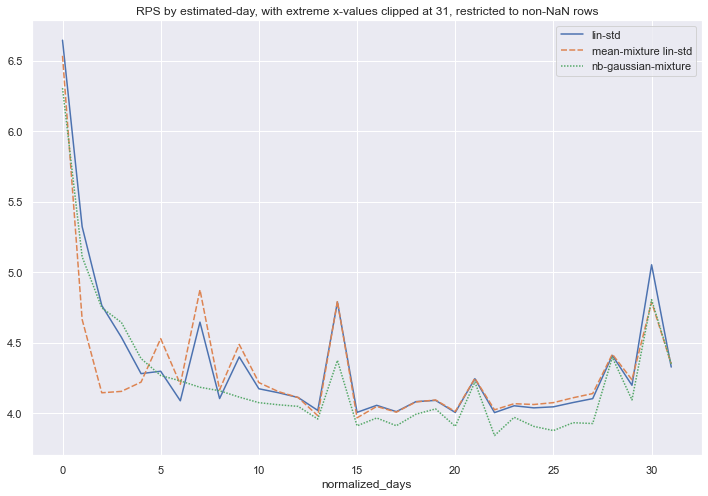

In [113]:
distros_df['nb-gaussian-mixture'] = nb_gaussian_score_distro
ax = plot_distros_df(distros_df, policy='clip', value=31, exclude=['unif', 'nb', 'zinb'],
                     mask=non_nan_rows) # only consider rows with 0 NaN values
ax.set_title("RPS by estimated-day, with extreme x-values clipped at 31, restricted to non-NaN rows")
plt.show()

Conclusions:

* The quotient between the target stock and the mean sellings of the last two weeks is a decent predictor for the inventory days target, specially considering how simple it is.
* Not only it is a good predictor, it's also a good indicator of *ill-conditioned* rows: those with invalid (outside of the [[1;30]] range) or extreme (barely >1 or <30) values for this metric have unstable behavior, where the target\_days do not distribute in the same way they do for well-conditioned rows (see row-normalized heatmap for estimated-day values 0,1,30,31)
* The best model family by far and away was the day-scaling-dispersion gaussian model, where also these variants showed improvements over others:
    * The more aggressive policy of scaling the variance with the squared predicted days instead of linearly
    * Using a mixture of centrality measures for quickly stabilizing the metric (see [0;5] interval in the above graphics)
* Constant-p bernoulli models failed at capturing the whole spectrum, although if restricted to non-NaN rows pure NB seems to do very well in the first half (due to low dispersion being better in such cases) for this validation set and the ZeroInflated-NB being decent in the second half (although strictly worse than gaussian models).
* Linear combinations of NB and Gaussian/ZI-NB models were explored and they make sense from a model hypothesis PoV: if variability increases with expected days, then a expected-days-weighted average of low- and high-variability models should perform better than each individually. In order to avoid incurring in data leakage, the $4.4$ valid-set RPS should only be taken as a "sign of being onto something".
* There seems to be a mixture of three "forces" or families of time-series at play here:
    * A nullifying series (rows tend to be zero-inflated)
    * Peaking series (could be holiday-related, or more generally yearly-seasonal trends of which holidays are a special case)
    * Steady-state series (the "everyday" ones)
* Modelling such mixtures requires at the very least changing the approach to a T-S one for adding exogenous variables, which is less than ideal for hardware-capped gear.
* While achieving a promising $4.4526$ whole-validation-set RPS, basic modelling seems to have reached a limit for expression capability (without ensembles like the NB-Gaussian) and actual regressor models are recommended for better capturing the time-series. In this regard, working with only non-nan rows is expected to be better and then for the NaN rows use either of the following:
    * a default model, such as the nb-gaussian-mixture or the mean-mixture gaussian, as they support NaN problems
    * a similarity-based approach for bypassing the need for the T-S information and predicting only based on similar SKUs with well-behaved rows.
    
For future work, the following is a ranking of validation-set RPS's for the models considered when restricting the dataset to non-NaN rows.

In [114]:
print((distros_df
       .drop(columns=['zeroes_per_row', 'normalized_days_14', 'normalized_days_full'])
       [non_nan_rows]
       .mean(axis=0))
       .sort_values())

nb-gaussian-mixture     4.398238
mean-mixture lin-std    4.446253
lin-std                 4.515642
zinb                    4.822091
unif                    4.867235
nb                      5.941146
dtype: float64


Considering public and private leaderboard RPS scores were a little below 1.1 times this validation-set RPS score for Uniform and Linear-std, the NB-Gaussian mixture would have gotten around $4.838$ PRIV-LB RPS and the Mean-mixture Linear-std model around $4.89088$ PRIV-LB RPS achieving around rank 57 and 61 respectively with models so simple that barely classify as Machine Learning ones (**they're simpler than a decision tree**).